# Clean Notebook for Webscraping of Blueground

Clean means: You can start from top an run to bottom without an error

# We load the libraries

In [15]:
# import all libraries that are needed

import requests                 # requests on websites
from bs4 import BeautifulSoup   # html parsing

import pandas as pd             # pandas for data frame
import numpy as np              # numpy for array

import math                     # for math methods
import time                     # for sleep timer


from sql_functions import *     # functions from file for upload on schema
import psycopg2                 # for upload on engine

# Import the get_engine function from our sql_functions.
from sql_functions import get_engine #adjust this as necessary to match your sql_functions.py connection methods

# Import get_dataframe from sql_functions.py
from sql_functions import get_dataframe

# create a variable called engine using the get_engine function
engine = get_engine()

import datetime                 # for date and time
import datetime as dt           # for the csv file with the current date and time
from datetime import date       # for the current date

import re                       # for regular expressions

# https://jsonformatter.org/json-viewer
import json                     # for json files

import random                   # for random numbers

# https://jwalton.info/Matplotlib-custom-boxplots/
import itertools

import matplotlib.pyplot as plt # for plotting
# Will allow us to embed images in the notebook
%matplotlib inline
from matplotlib.cbook import _reshape_2D

# Seaborn visualization library
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
import seaborn as sns

# we create empty dataframes

In [16]:
# create an empty dataframe
df_full = pd.DataFrame()
df_object = pd.DataFrame()
df_search = pd.DataFrame()
df_detail = pd.DataFrame()
df = pd.DataFrame()

# we set up the link and stuff for the loop

In [17]:
#original = weblink = 'https://www.theblueground.com/furnished-apartments-london-uk/s/hammersmith,fulham,kensington,chelsea,camden-town,westminster,city-of-london,hackney,stockwell,vauxhall,waterloo,limehouse,wapping,whitechapel-brick-lane,islington,bromley-by-bow?currency=GBP&language=en&offset=0&items=18'
#weblink = 'https://www.theblueground.com/furnished-apartments-london-uk?currency=GBP&language=en&'
original = weblink = 'https://www.theblueground.com/api/furnished-apartments-london-uk?subArea=bromley-by-bow,camden-town,chelsea,city-of-london,fulham,hackney,hammersmith,islington,kensington,stockwell,vauxhall,westminster,whitechapel-brick-lane,limehouse,wapping,waterloo&currency=GBP&language=en&offset=1&items=18'
weblink = weblink.replace("/api", "")
weblink = (weblink[:-10])

print(original)
print(weblink)

https://www.theblueground.com/api/furnished-apartments-london-uk?subArea=bromley-by-bow,camden-town,chelsea,city-of-london,fulham,hackney,hammersmith,islington,kensington,stockwell,vauxhall,westminster,whitechapel-brick-lane,limehouse,wapping,waterloo&currency=GBP&language=en&offset=1&items=18
https://www.theblueground.com/furnished-apartments-london-uk?subArea=bromley-by-bow,camden-town,chelsea,city-of-london,fulham,hackney,hammersmith,islington,kensington,stockwell,vauxhall,westminster,whitechapel-brick-lane,limehouse,wapping,waterloo&currency=GBP&language=en&offset=


In [18]:
# set up the link to the website

#weblink = 'https://www.theblueground.com/furnished-apartments-london-uk?currency=GBP&language=en&'

# set up the first page to scrape
# problems with scraping the first page, so we start with the second page
pagesite = 1 # the website will start with 0 / # we set it to 10 to test the code

# create an empty list to store the blank slates
blank_slates_lst = [] 

# set the stop condition
stop_loop = "We’re sorry! We can’t seem to find any apartments that match your search." 

# check the link
full_link = (weblink +  f'{ pagesite }&items=18')
print(full_link)
#print((weblink +  f'offset={ pagesite }&items=18'))
print((weblink +  f'{ pagesite }&items=18'))


https://www.theblueground.com/furnished-apartments-london-uk?subArea=bromley-by-bow,camden-town,chelsea,city-of-london,fulham,hackney,hammersmith,islington,kensington,stockwell,vauxhall,westminster,whitechapel-brick-lane,limehouse,wapping,waterloo&currency=GBP&language=en&offset=1&items=18
https://www.theblueground.com/furnished-apartments-london-uk?subArea=bromley-by-bow,camden-town,chelsea,city-of-london,fulham,hackney,hammersmith,islington,kensington,stockwell,vauxhall,westminster,whitechapel-brick-lane,limehouse,wapping,waterloo&currency=GBP&language=en&offset=1&items=18


In [19]:
if original == full_link:
    print("yes")
else:
    print("no")

no


## we need the following structure for the dataframe, from the website
+ platform_id
+ platform
+ neighbourhood
+ furniture
+ property_type
+ size_sqm
+ bedrooms
+ bathrooms
+ price
+ price_sqm
+ price_bedroom
+ available_from
+ available_today
+ let_type
+ original_furniture
+ scraping_date

# Neighbourhoods Ukio wants from us

+ Camden
+ City of London
+ City of Westminster
+ Hackney
+ Hammersmith and Fulham
+ Islington
+ Kensington and Chelsea
+ Lambeth --> Vauxhall
+ Tower Hamlets

### List of Neighbourhoods from Blueground we have to use

+ Hammersmith
+ Fulham
+ Kensington
+ Chelsea
+ Camden
+ Westminster
+ City of London
+ Hackney
+ Stockwell
+ Vauxhall
+ Waterloo
+ Bromley-by-Bow
+ Limehouse
+ Wapping
+ Whitechapel
+ Islington

-----

# we load all the functions

platform_id --> we get the ID from the last part of the URL for every apartment

In [20]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html

def get_blueground_id(df_search):
    # create an empty list to store the blueground_id
    blueground_id_lst = []
    # get the blueground_id from the dataframe and the column get_url_to_detail_page
    for blueground_id in df_search.get_url_to_detail_page: # we get the url from the dataframe
        blueground_id_lst.append(blueground_id.rsplit('-', 1)[-1]) # we get the last part of the url
    return blueground_id_lst

platform --> we can add the Origin-Platform during the Loop, in this Notebook we have only "blueground"

neighbourhood

In [21]:
def get_neighborhoods(bs):
    neighborhood_names = bs.find_all("div", {"class":"name-place"})
    neighborhood_names_lst = (neighborhood_name.get_text() for neighborhood_name in neighborhood_names)
    neighborhood_names_lst = [neighborhood_name.strip() for neighborhood_name in neighborhood_names_lst]
    neighborhood_names_lst = [i.rsplit(',', 1)[-1] for i in neighborhood_names_lst]
    neighborhood_names_lst = [i.rsplit('-', 1)[0] for i in neighborhood_names_lst]
    neighborhood_names_lst = [i.strip() for i in neighborhood_names_lst]
    return neighborhood_names_lst

property_type 
on Blueground their is only "Studio" or "Apartment"

> later we have to change the Type  "Jr. Bedroom" to "Studio"

In [22]:
def get_property_type(bs):
    # get the property_type out of the apartment amenities
    lst_name = []
    property_typs = bs.find_all(class_="main-amenities")
    property_typs_lst = [property_type.get_text() for property_type in property_typs]
    property_typs_lst = [property_type.strip() for property_type in property_typs_lst]
    property_typs_lst = [i.split('o', 1)[0] for i in property_typs_lst]
    property_typs_lst = [i.replace('Bedr', 'Bedroom') for i in property_typs_lst]
    property_typs_lst = [i.replace('Studi', 'Studio') for i in property_typs_lst]
    property_typs_lst = [i.rsplit(' ', 1)[-1] for i in property_typs_lst]
    return property_typs_lst

bedrooms

In [23]:
def get_bedrooms(bs):
    # get the main-amenities of the apartments
    lst_name = []
    bedrooms = bs.find_all(class_="main-amenities")
    bedrooms_lst = [bedroom.get_text() for bedroom in bedrooms]
    bedrooms_lst = [bedroom.strip() for bedroom in bedrooms_lst]
    bedrooms_lst = [i.split('o', 1)[0] for i in bedrooms_lst]
    bedrooms_lst = [i.replace('Bedr', 'Bedroom') for i in bedrooms_lst]
    bedrooms_lst = [i.replace('Studi', 'Studio') for i in bedrooms_lst]
    return bedrooms_lst

bathroom

In [24]:
def get_bathroom(bs):
    # get the main-amenities of the apartments
    lst_name = []
    bathrooms= bs.find_all(class_="main-amenities")
    bathrooms_lst = [bathroom.get_text() for bathroom in bathrooms]
    bathrooms_lst = [bathroom.strip() for bathroom in bathrooms_lst]
    bathrooms_lst = [i.rsplit('o', 1)[-1] for i in bathrooms_lst]
    bathrooms_lst = [i.replace('m', '') for i in bathrooms_lst]

    return bathrooms_lst

price_pcm (price per month)

In [25]:
def get_price_pcm(bs):
    # get the price per month
    lst_name = []
    prices = bs.find_all(class_= "price__amount")
    for price in prices:
        lst_name.append(
            price.get_text()
                .strip()
                .replace(',', '')
        )
    return lst_name

 title

In [26]:
def get_object_title(bs):
    # get the names of all the apartments
    lst_name = []
    object_titles = bs.find_all(class_="listing-name")
    for object_title in object_titles:
        lst_name.append(
            object_title.get_text()
                .strip()
        )
    return lst_name


furnished --> on Blueground we have only furnished Studios/Apartments

available_from

In [27]:
def get_availability(bs):
    # get the availability of the apartments
    lst_availability = []
    availability = bs.find_all(class_="availability__date")
    for avail in availability:
        lst_availability.append(
            avail.get_text()
                .strip()
        )
    return lst_availability


size --> we get the size (sqm) in an extra loop, after the main information

-----

# We need this for the extra details

url

In [28]:
def get_url_to_detail_page(bs, maximus):
    url_lst = []
    count = 0
    while count <= int(maximus):
        
        # this will get us the link to the detail page
        class_with_link = bs.find_all(class_="ui-image-carousel")
        # with the [] we can select the elment we want to get
        for a in class_with_link[count].find_all('a', href=True):
            url_lst.append(a['href'])
        count += 1
    #print(url_lst)
    return url_lst

----

# the Loop to grab everything for the main information

In [29]:
# https://flexiple.com/python/check-if-list-is-empty-python/
# Solution 3: Using len() function
# The len() function returns the number of items in a list. If the list is empty, it returns 0.
while len(blank_slates_lst) == 0: # start and endpoint of the for-loop
    # pause the loop for a raondom time to reduce the load on the server
    #time.sleep(random.randint(5,15)/random.randint(1,9))
    time.sleep(3)

    # ----------------- get the data from the website -----------------
    # get the content of the website
    page = requests.get(weblink +  f'offset={ pagesite }&items=18')
    page = requests.get(weblink +  f'{ pagesite }&items=18')
    # parse the html and save it into a BeautifulSoup instance
    html = page.content
    bs = BeautifulSoup(html, 'html.parser')

    # ----------------- insert the data into the dataframe -----------------
    # create a pandas dataframe for the names and prices
    blueground_dict = {
        #'platform_id', --> we get this from the detail page
        'platform': 'Blueground',
        'neighbourhood': get_neighborhoods(bs),
        'property_type': get_property_type(bs),
        'bedrooms': get_bedrooms(bs),
        'bathroom': get_bathroom(bs),
        'price_pcm': get_price_pcm(bs),
        'title': get_object_title(bs),
        'furniture': 'furnished',
        'detailed_furniture': 'furnished',
        'available_from': get_availability(bs),
        #'size': , --> we get this from the detail page
        'title': get_object_title(bs),
        'scraping_date_main': date.today(), # today's date
        'available_today': ''
        }
    display(blueground_dict)
    # ----------------- work with the datafram to get the URL and the ID -----------------
    # we now have a dataframe, we can use this to get a counter for the URL
    #df_page = pd.DataFrame(blueground_dict)
    df_page = pd.DataFrame.from_dict(blueground_dict)
    df_page = df_page.reset_index(drop=True)

    # we create a variable to store the number of rows in the dataframe
    maximus = df_page.index.max() # we give it the max value of the index

    # we create a list to store the urls
    # we check if we reached the end of the existing df, to stop and not get an error
    if np.isnan(maximus):
        break
    else:
        df_page['get_url_to_detail_page'] = pd.Series(get_url_to_detail_page(bs, maximus))
    # we can now add the dataframe to the full dataframe
    df_search = pd.concat([df_search, df_page], axis=0, ignore_index=True)
    df_search = df_search.reset_index(drop=True)

    # ----------------- check if we reached the end of the pages -----------------
    blank_slates = bs.find_all(class_="blank-slate__criteria")
    blank_slates_lst = (blank_slate.get_text() for blank_slate in blank_slates)
    blank_slates_lst = [blank_slate.strip() for blank_slate in blank_slates_lst]

    # increase the pagesite by 1
    pagesite += 1


# ----------------- get the ID from URL -----------------
# we want the ID on the first place, so we can use it to merge the dataframes, if needed
# Third position would be at index 2, because of zero-indexing.
df_search.insert(0, 'platform_id', get_blueground_id(df_search))

{'platform': 'Blueground',
 'neighbourhood': ['Waterloo',
  'Islington',
  'Vauxhall',
  'Waterloo',
  'Fulham',
  'Bromley by Bow',
  'Whitechapel/Brick Lane',
  'Islington',
  'Bromley by Bow',
  'Limehouse',
  'Limehouse',
  'Whitechapel/Brick Lane',
  'City of London',
  'Kensington',
  'Whitechapel/Brick Lane',
  'Vauxhall'],
 'property_type': ['Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom'],
 'bedrooms': ['2 Bedroom',
  '2 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  'Jr. 1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '2 Bedroom'],
 'bathroom': ['2 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1

{'platform': 'Blueground',
 'neighbourhood': ['City of London',
  'Kensington',
  'Whitechapel/Brick Lane',
  'Whitechapel/Brick Lane',
  'Kensington',
  'City of London',
  'Chelsea',
  'City of London',
  'Vauxhall',
  'Whitechapel/Brick Lane',
  'Waterloo',
  'Vauxhall',
  'Camden Town',
  'Vauxhall',
  'Chelsea',
  'Vauxhall'],
 'property_type': ['Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Studio',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom'],
 'bedrooms': ['1 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  'Jr. 1 Bedroom',
  '2 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  'Studio',
  '2 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  '2 Bedroom',
  '1 Bedroom',
  '1 Bedroom'],
 'bathroom': ['1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '2 Bath',
  '1 Bath',
  '1.5 Bath',
  '1 Bath',
  '2 Bath',
  '1 Bath',
  '2 Bath',
  '1 Bath',
  '2 Bath',
  '2 Bath',
  '1 

{'platform': 'Blueground',
 'neighbourhood': ['Waterloo',
  'Whitechapel/Brick Lane',
  'Whitechapel/Brick Lane',
  'Vauxhall',
  'Wapping',
  'Waterloo',
  'Whitechapel/Brick Lane',
  'Kensington',
  'Islington',
  'Vauxhall',
  'Waterloo',
  'Hackney',
  'City of London',
  'Vauxhall',
  'Whitechapel/Brick Lane',
  'Vauxhall'],
 'property_type': ['Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom'],
 'bedrooms': ['2 Bedroom',
  '2 Bedroom',
  '2 Bedroom',
  '2 Bedroom',
  '2 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  '2 Bedroom',
  '3 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  '2 Bedroom'],
 'bathroom': ['2.5 Bath',
  '2 Bath',
  '1 Bath',
  '2 Bath',
  '2 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '2 Bath',
  '2 Bath',
  '2 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '2.5 

{'platform': 'Blueground',
 'neighbourhood': ['Waterloo',
  'Whitechapel/Brick Lane',
  'Waterloo',
  'Waterloo',
  'Bromley by Bow',
  'Waterloo',
  'Fulham',
  'Whitechapel/Brick Lane',
  'Waterloo',
  'Kensington',
  'Waterloo',
  'Waterloo'],
 'property_type': ['Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Studio',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Bedroom',
  'Studio',
  'Bedroom'],
 'bedrooms': ['2 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  'Studio',
  '2 Bedroom',
  '1 Bedroom',
  '1 Bedroom',
  '2 Bedroom',
  '1 Bedroom',
  'Studio',
  '2 Bedroom'],
 'bathroom': ['2 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '1 Bath',
  '2 Bath',
  '1 Bath',
  '1 Bath',
  '2 Bath',
  '1 Bath',
  '1 Bath',
  '2 Bath'],
 'price_pcm': ['4160',
  '3900',
  '3430',
  '3770',
  '2810',
  '4540',
  '4150',
  '4620',
  '4460',
  '3800',
  '3470',
  '5560'],
 'title': ['Lower Marsh,',
  'Cavell St,',
  'Lower Marsh,',
  'Lower Marsh,',
  'Skyline Apartments, G

{'platform': 'Blueground',
 'neighbourhood': [],
 'property_type': [],
 'bedrooms': [],
 'bathroom': [],
 'price_pcm': [],
 'title': [],
 'furniture': 'furnished',
 'detailed_furniture': 'furnished',
 'available_from': [],
 'scraping_date_main': datetime.date(2022, 10, 23),
 'available_today': ''}

In [30]:
# show the link, just to check if it works
print("The pagesite ends with:", pagesite)
print("The last link would be:", (weblink +  f'offset={ pagesite }&items=18'))

The pagesite ends with: 5
The last link would be: https://www.theblueground.com/furnished-apartments-london-uk?subArea=bromley-by-bow,camden-town,chelsea,city-of-london,fulham,hackney,hammersmith,islington,kensington,stockwell,vauxhall,westminster,whitechapel-brick-lane,limehouse,wapping,waterloo&currency=GBP&language=en&offset=offset=5&items=18


In [17]:
#------- set the number of rows and column_width  to maximum ------- 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

In [ ]:
break

In [31]:
# ----------------- display the first 5 rows -----------------
display(df_search.head(2))
display(df_search.tail(2))

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,available_from,scraping_date_main,available_today,get_url_to_detail_page
0,106,Blueground,Waterloo,Bedroom,2 Bedroom,2 Bath,3980,"Lower Marsh,",furnished,furnished,14 Nov 2022,2022-10-23,,/furnished-apartments-london-uk/london-waterlo...
1,232,Blueground,Islington,Bedroom,2 Bedroom,1 Bath,3390,"Kings Quarter Apartments, Copenhagen St,",furnished,furnished,20 Nov 2022,2022-10-23,,/furnished-apartments-london-uk/london-islingt...


,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,available_from,scraping_date_main,available_today,get_url_to_detail_page
58,262,Blueground,Waterloo,Studio,Studio,1 Bath,3470,"Walpole House, Westminster Bridge Rd,",furnished,furnished,17 Sep 2023,2022-10-23,,/furnished-apartments-london-uk/london-waterlo...
59,196,Blueground,Waterloo,Bedroom,2 Bedroom,2 Bath,5560,"West Block, Forum Magnum Square,",furnished,furnished,19 Sep 2023,2022-10-23,,/furnished-apartments-london-uk/london-waterlo...


In [19]:
# shows us the shape of the df in a quick way
df_search.shape

(60, 14)

### we create some copys to work with

In [20]:
print(df_search.index)
df_save = df_search.copy()
print(df_save.index)

RangeIndex(start=0, stop=60, step=1)
RangeIndex(start=0, stop=60, step=1)


--------

# Information from the JSON-File, we can create of the Detail-Webpages

In [21]:
# make a copy of the dataframe, so we can use it later
df_for_details = df_save.copy()

In [22]:
#-------- create empty dataframe to store the data in ---------
df_detail = pd.DataFrame()
concatenated = pd.DataFrame()
df2 = pd.DataFrame()


# ----- we need to loop through the dataframe, to get the details from the detail page -----
for idx, row in df_for_details.iterrows():
    # pause the loop for a raondom time to reduce the load on the server
    #time.sleep(random.randint(2,15)/random.randint(1,9))
    time.sleep(3)
    
    #page = 'https://www.theblueground.com/furnished-apartments-london-uk/london-clerkenwell-115' # for testing
    page_start = 'https://www.theblueground.com'    # this is the main part of the URL
    page_end = row['get_url_to_detail_page']        # we get the rest of the URL from the dataframe
    pp = page_start + page_end                      # we combine the two parts of the URL
    #print(pp)                                      # for testing

# ----------------- get the data from the website -----------------
    website = requests.get(pp)
    results = BeautifulSoup(website.content, 'html.parser')

    detailed_pages = results.findAll('div', class_='property__amenities-list-item')
    detailed_pages = results.findAll()

    detailed_pages_lst = (detailed_page.get_text() for detailed_page in detailed_pages)
    detailed_pages_lst = [detailed_page.strip() for detailed_page in detailed_pages_lst]

    df = pd.DataFrame(detailed_pages_lst, columns=['details'])
    #display(df)                                    # for testing

# ----------------- first steps to prepare a Json-File from the output we create from the detail-webpage -----------------
    df2 = df['details'].str.split('property:', expand=True).tail(1)
    df_to_string = str(df2[1].values[0])
    
    # we need to remove the last characters, so we get a valid json 
    df_to_string = df_to_string.strip()            
    df_to_string = df_to_string.rstrip(';')         # remove the last character
    df_to_string = df_to_string.strip()             
    df_to_string = df_to_string.rstrip('}')         # remove the last character
    df_to_string = df_to_string.strip()

# ----------------- create a Json-File from the output we create from the detail-webpage -----------------
    detail_dict = json.loads(df_to_string)
    detail_dict_normalized = pd.json_normalize(detail_dict, sep='_')
    x = detail_dict_normalized['amenities_main'].values[0]

# ----------------- with every loop we can crap the same information out of the Json-File -----------------
    df_detail = []
    df_detail = pd.DataFrame({
                        'blueground_id_details': page_end.rsplit('-', 1)[-1],
                        "lotsize":[x[2]['key']],                 # lotsize
                         "size_ft":x[2]['value'],                # lotsize value, the actual sqm as a number
                         'caption':x[2]['caption'],              # sqm as a caption
                         'scraping_date_details': date.today(),  # today's date
                         'let_type': ''                         # mostly used by another company, so we can ignore it
                         })
# ----------------- we can now add the data to the dataframe -----------------
    concatenated = pd.concat([concatenated, df_detail], axis=0, ignore_index=True, join='outer')


In [23]:
# ----------------- we can now show the data of the dataframe -----------------
display(concatenated.head(2))
display(concatenated.tail(2))

,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type
0,232,lotSizeSF,620,sq. ft.,2022-10-21,
1,129,lotSizeSF,620,sq. ft.,2022-10-21,


,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type
58,262,lotSizeSF,699,sq. ft.,2022-10-21,
59,196,lotSizeSF,998,sq. ft.,2022-10-21,


In [24]:
# shows us the shape of the df in a quick way
concatenated.shape

(60, 6)

# Save the Data

In [25]:
# ----------------- save the dataframes in a .csv file -----------------
today = dt.datetime.today().strftime('%Y-%m-%d-%H-%M')
df_search.to_csv('data/bluebround_main_{}.csv'.format(today), sep='\t')
concatenated.to_csv('data/bluebround_detail_{}.csv'.format(today), sep='\t')
print("We have saved the new dataframes in a .csv file")

OSError: Cannot save file into a non-existent directory: 'data'

----

# 1. Basic information about data - EDA, before we export to DBeaver

https://www.digitalocean.com/community/tutorials/exploratory-data-analysis-python

In [36]:
#Basic information
print(df_search.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   platform_id             60 non-null     object
 1   platform                60 non-null     object
 2   neighbourhood           60 non-null     object
 3   property_type           60 non-null     object
 4   bedrooms                60 non-null     object
 5   bathroom                60 non-null     object
 6   price_pcm               60 non-null     object
 7   title                   60 non-null     object
 8   furniture               60 non-null     object
 9   detailed_furniture      60 non-null     object
 10  available_from          60 non-null     object
 11  scraping_date_main      60 non-null     object
 12  available_today         60 non-null     object
 13  get_url_to_detail_page  60 non-null     object
dtypes: object(14)
memory usage: 6.7+ KB
None


In [37]:
#Basic information
print(concatenated.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   blueground_id_details  60 non-null     object
 1   lotsize                60 non-null     object
 2   size_ft                60 non-null     object
 3   caption                60 non-null     object
 4   scraping_date_details  60 non-null     object
 5   let_type               60 non-null     object
dtypes: object(6)
memory usage: 2.9+ KB
None


# 2. Duplicate values

In [38]:
#Find the duplicates
print(df_search.duplicated().sum())
print(concatenated.duplicated().sum())

0
0


# 5. Find the Null values

In [39]:
#Find null values
print(df_search.isnull().sum())
print(concatenated.isnull().sum())

platform_id               0
platform                  0
neighbourhood             0
property_type             0
bedrooms                  0
bathroom                  0
price_pcm                 0
title                     0
furniture                 0
detailed_furniture        0
available_from            0
scraping_date_main        0
available_today           0
get_url_to_detail_page    0
dtype: int64
blueground_id_details    0
lotsize                  0
size_ft                  0
caption                  0
scraping_date_details    0
let_type                 0
dtype: int64


# 7. Know the datatypes

In [40]:
#Datatypes
print(df_search.dtypes)
print(concatenated.dtypes)

platform_id               object
platform                  object
neighbourhood             object
property_type             object
bedrooms                  object
bathroom                  object
price_pcm                 object
title                     object
furniture                 object
detailed_furniture        object
available_from            object
scraping_date_main        object
available_today           object
get_url_to_detail_page    object
dtype: object
blueground_id_details    object
lotsize                  object
size_ft                  object
caption                  object
scraping_date_details    object
let_type                 object
dtype: object


------

# Deleting all existing Tables in DBeaver

In [41]:
# Delete blueground_df_main table if it exists
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.blueground_df_main;
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [42]:
# Delete blueground_main_details table if it exists
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.blueground_main_details;
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [43]:
# Delete blueground_df_details table if it exists
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.blueground_df_details;
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [44]:
# Delete blueground_eda_cleaned table if it exists
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.blueground_eda_cleaned;
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [45]:
# Delete blueground_clean table if it exists
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.blueground_clean;
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

-------

# Export the data frame to DBeaver

## Export the Main-DF to DB

In [46]:
# export the data frame to DBeaver

# call the schema created for this project
schema = 'capstone_jmrs'

# give the table a unique name
table_name = 'blueground_df_main'

# export the table to sql
if engine!=None:
    try:
        df_search.to_sql(name=table_name,
                        con=engine,
                        if_exists='replace',
                        schema=schema, 
                        index=False,
                        chunksize=5000, 
                        method='multi')
        print(f"The {table_name} table was imported successfully.")
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The blueground_df_main table was imported successfully.


## Export the Detail-DF to DBeaver

In [47]:
# export the data frame to DBeaver

# call the schema created for this project
schema = 'capstone_jmrs'

# give the table a unique name
table_name = 'blueground_df_details'

# export the table to sql
if engine!=None:
    try:
        concatenated.to_sql(name=table_name,
                        con=engine,
                        if_exists='replace',
                        schema=schema, 
                        index=False,
                        chunksize=5000, 
                        method='multi')
        print(f"The {table_name} table was imported successfully.")
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The blueground_df_details table was imported successfully.


-------

# Do manipulation in SQL - Language

In [48]:
# call the schema created for this project
schema = 'capstone_jmrs'

In [49]:
# Part 1 - Change all the Data - Values, we can easily change
# https://www.techonthenet.com/postgresql/tables/alter_table.php

sql_text = f"""
ALTER TABLE {schema}.blueground_df_main
  ALTER COLUMN platform_id  			TYPE integer USING platform_id::integer,
  ALTER COLUMN platform 				  TYPE varchar,
  ALTER COLUMN neighbourhood 			TYPE varchar,
  ALTER COLUMN property_type 			TYPE varchar,
  ALTER COLUMN title 					    TYPE varchar,
  ALTER COLUMN furniture 				  TYPE varchar,
  ALTER COLUMN detailed_furniture 				  TYPE varchar,
  ALTER COLUMN get_url_to_detail_page 	TYPE varchar,
  ALTER COLUMN available_today 	  TYPE  varchar,
  ALTER COLUMN available_from     TYPE date USING available_from::date ;  
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [50]:
# Part 2 -  We have to edit the values from "BedRooms, BathRooms and Price_Pcm" to convert it to an integer or float
# currently, we have "String" in this cells
# https://www.postgresqltutorial.com/postgresql-tutorial/postgresql-update/


# We change the Values of the Bedrooms

sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bedrooms = 1
WHERE bedrooms = '1 Bedroom' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bedrooms = 2
WHERE bedrooms = '2 Bedroom' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bedrooms = 3
WHERE bedrooms = '3 Bedroom' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [51]:
# Update the property_type to Studio, if the  bedrooms is a Jr. 1 Bedroom
sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  property_type = 'Studio',
	 bedrooms = 1
WHERE bedrooms = 'Jr. 1 Bedroom' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

#we Update the Studio in "Bedroom" to 0 (Zero), to convert them later to Integer or Float
sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bedrooms = '0'
WHERE bedrooms = 'Studio' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [52]:
# Update the property_type to Apartment, if the property_type is Bedroom
sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  property_type = 'Apartment'
WHERE property_type = 'Bedroom' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [53]:
# now we will update the bathrooms ----
sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bathroom = 1
WHERE bathroom = '1 Bath' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bathroom = 1.5
WHERE bathroom = '1.5 Bath' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bathroom = 2
WHERE bathroom = '2 Bath' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  bathroom = 2.5
WHERE bathroom = '2.5 Bath' ;
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)


In [54]:
# now we want to ALTER the column of Bedrooms to Integer
sql_text = f"""
ALTER TABLE {schema}.blueground_df_main
  ALTER COLUMN bedrooms  TYPE integer USING (trim(bedrooms)::integer);
  """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)
  
# now we want to Alter the column of Bathroom to Float  
sql_text = f"""
ALTER TABLE {schema}.blueground_df_main
  ALTER COLUMN bathroom  TYPE float USING (trim(bathroom)::float);
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

#  now we want to Alter the column of Price to an Integer
sql_text = f"""
ALTER TABLE {schema}.blueground_df_main
ALTER COLUMN price_pcm  TYPE integer USING (trim(price_pcm)::integer) ; 
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [55]:
# Part 4 -  We have to Update the neighborhood's to make it even with the requirements from Uki
 # currently, we have "String" in this cells
 # https://www.postgresqltutorial.com/postgresql-tutorial/postgresql-update/

 # Update to Hammersmith and Fulham
sql_text = f"""
UPDATE {schema}.blueground_df_main
SET  neighbourhood = 'Hammersmith and Fulham'
WHERE (neighbourhood = 'Hammersmith') OR (neighbourhood = 'Fulham'); 
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)


# Update to Kensington and Chelsea
sql_text = f"""
 UPDATE {schema}.blueground_df_main
SET  neighbourhood = 'Kensington and Chelsea'
WHERE (neighbourhood = 'Kensington') OR (neighbourhood = 'Chelsea'); 
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

# Update to Camden
sql_text = f"""
 UPDATE {schema}.blueground_df_main
SET  neighbourhood = 'Camden'
WHERE (neighbourhood = 'Camden Town'); 
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

# City of Westminster
sql_text = f"""
 UPDATE {schema}.blueground_df_main
SET  neighbourhood = 'City of Westminster'
WHERE (neighbourhood = 'Westminster');
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

# Update to Lambeth
sql_text = f"""
 UPDATE {schema}.blueground_df_main
SET  neighbourhood = 'Lambeth'
WHERE (neighbourhood = 'Stockwell') OR (neighbourhood = 'Vauxhall') OR (neighbourhood = 'Waterloo'); 
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

# Update to Tower of Hamlets
sql_text = f"""
 UPDATE {schema}.blueground_df_main
SET  neighbourhood = 'Tower Hamlets'
WHERE (neighbourhood = 'Bromley by Bow') OR (neighbourhood = 'Bromley-by-Bow') OR (neighbourhood = 'Limehouse')OR (neighbourhood = 'Wapping') OR (neighbourhood = 'Whitechapel')OR (neighbourhood = 'Whitechapel/Brick Lane'); 
""" 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)


In [56]:
today = date.today() 
print("Today's date:", today)

Today's date: 2022-10-21


In [57]:
tomorrow = datetime.datetime.now() + datetime.timedelta(days=1)
print("Today's date + 1 will be (we also call it Tomorrow):", tomorrow.date())

Today's date + 1 will be (we also call it Tomorrow): 2022-10-22


In [58]:
sql_text = f"""
 UPDATE {schema}.blueground_df_main
	SET available_today = CASE 
      						WHEN available_from = '{tomorrow}'   THEN 'available'
      						ELSE 'occupied'
						  END;
 """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [59]:
 # Part 5 -  We now have to update the Types of the Detail
 # currently, we have "String" in this cells
 # https://www.postgresqltutorial.com/postgresql-tutorial/postgresql-update/
sql_text = f"""
 ALTER TABLE {schema}.blueground_df_details
 ALTER COLUMN  blueground_id_details 	TYPE integer USING blueground_id_details::integer,
 ALTER COLUMN  lotsize			TYPE varchar,
 ALTER COLUMN  size_ft			TYPE float USING (trim(size_ft)::float),
 ALTER COLUMN  caption			TYPE varchar;
 """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

-------

# Combinded Data
Now we have to combined the Table of the Main Data and the Detail-Data.    
We also executed some SQL-Functions for cleaning and preparation.

In [60]:
 # Part 6 -  We now create a new table from the Main and Detail-Tables
 # https://stackoverflow.com/questions/14065408/how-do-i-merge-two-tables-in-postgresql

sql_text = f"""
CREATE TABLE {schema}.blueground_main_details AS
SELECT *
FROM {schema}.blueground_df_main
LEFT JOIN  {schema}.blueground_df_details
	   ON blueground_df_main.platform_id  = blueground_df_details.blueground_id_details ;
        """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

## Previewing Data

In [61]:
# Schema / Database configure:
schema = 'capstone_jmrs'

# Table name:
table_name = 'blueground_main_details'

In [62]:
# Select the combined Data form DBeaver Database

sql = f"""

SELECT *
FROM {schema}.{table_name} as blueground_main_details


""" 
# Take the SQL-Command and import all Data from Air_Quality, from August 2021 
# to the variable aq_august
bgf = get_dataframe(sql) 
bgf_saved = bgf.copy()
display(bgf.head(3))

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,available_from,scraping_date_main,available_today,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type
0,232,Blueground,Islington,Apartment,2,1.0,3390,"Kings Quarter Apartments, Copenhagen St,",furnished,furnished,2022-11-20,2022-10-21,occupied,/furnished-apartments-london-uk/london-islington-232,232,lotSizeSF,620.0,sq. ft.,2022-10-21,
1,129,Blueground,Lambeth,Apartment,1,1.0,3520,"Exchange Gardens,",furnished,furnished,2022-11-20,2022-10-21,occupied,/furnished-apartments-london-uk/london-vauxhall-129,129,lotSizeSF,620.0,sq. ft.,2022-10-21,
2,123,Blueground,Lambeth,Apartment,1,1.0,3380,"Lower Marsh,",furnished,furnished,2022-11-21,2022-10-21,occupied,/furnished-apartments-london-uk/london-waterloo-123,123,lotSizeSF,565.0,sq. ft.,2022-10-21,


## Previewing Data

In [63]:
df = bgf

# Displays the top 5 rows. Accepts an optional int parameter - num. of rows to show
df.head(2)

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,available_from,scraping_date_main,available_today,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type
0,232,Blueground,Islington,Apartment,2,1.0,3390,"Kings Quarter Apartments, Copenhagen St,",furnished,furnished,2022-11-20,2022-10-21,occupied,/furnished-apartments-london-uk/london-islington-232,232,lotSizeSF,620.0,sq. ft.,2022-10-21,
1,129,Blueground,Lambeth,Apartment,1,1.0,3520,"Exchange Gardens,",furnished,furnished,2022-11-20,2022-10-21,occupied,/furnished-apartments-london-uk/london-vauxhall-129,129,lotSizeSF,620.0,sq. ft.,2022-10-21,


In [64]:
# Similar to head, but displays the last rows
df.tail(2)

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,available_from,scraping_date_main,available_today,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type
58,262,Blueground,Lambeth,Studio,0,1.0,3470,"Walpole House, Westminster Bridge Rd,",furnished,furnished,2023-09-17,2022-10-21,occupied,/furnished-apartments-london-uk/london-waterloo-262,262,lotSizeSF,699.0,sq. ft.,2022-10-21,
59,196,Blueground,Lambeth,Apartment,2,2.0,5560,"West Block, Forum Magnum Square,",furnished,furnished,2023-09-19,2022-10-21,occupied,/furnished-apartments-london-uk/london-waterloo-196,196,lotSizeSF,998.0,sq. ft.,2022-10-21,


In [65]:
# The dimensions of the dataframe as a (rows, cols) tuple
df.shape

(60, 20)

In [66]:
# Columns and their types
df.dtypes

platform_id                 int64
platform                   object
neighbourhood              object
property_type              object
bedrooms                    int64
bathroom                  float64
price_pcm                   int64
title                      object
furniture                  object
detailed_furniture         object
available_from             object
scraping_date_main         object
available_today            object
get_url_to_detail_page     object
blueground_id_details       int64
lotsize                    object
size_ft                   float64
caption                    object
scraping_date_details      object
let_type                   object
dtype: object

In [67]:
# Displays descriptive stats for all columns
df.describe()

,platform_id,bedrooms,bathroom,price_pcm,blueground_id_details,size_ft
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,160.133333,1.400000,1.375000,3951.000000,160.133333,630.883333
std,61.654716,0.616166,0.509445,890.619095,61.654716,222.102823
min,9.000000,0.000000,1.000000,2380.000000,9.000000,1.000000
25%,108.750000,1.000000,1.000000,3387.500000,108.750000,545.000000
50%,157.500000,1.000000,1.000000,3895.000000,157.500000,581.000000
75%,211.500000,2.000000,2.000000,4462.500000,211.500000,776.000000
max,262.000000,3.000000,2.500000,5950.000000,262.000000,1331.000000


--------

# After we have done some EDA, we need to manipulate the Data to create addional coloums

## Calculate the "Square Feet" to "Square Meters"
formula: m² = ft² / 10.764

#### What Is Price Per Square Meter?

##### Dividing Total Cost by Total Area to Calculate Price Per Square Meter
The following table has Total Area in m2, Total Price, and Price/m2 columns. We will calculate price per square meter by `dividing` the `Total Price` by `Total Area in m2`.

In [68]:
df.eval('size_sqm = size_ft / 10.764', inplace=True)
df.size_sqm = round(df.size_sqm, 2)

display(df.head(3))

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,scraping_date_main,available_today,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm
0,232,Blueground,Islington,Apartment,2,1.0,3390,"Kings Quarter Apartments, Copenhagen St,",furnished,furnished,...,2022-10-21,occupied,/furnished-apartments-london-uk/london-islington-232,232,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.60
1,129,Blueground,Lambeth,Apartment,1,1.0,3520,"Exchange Gardens,",furnished,furnished,...,2022-10-21,occupied,/furnished-apartments-london-uk/london-vauxhall-129,129,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.60
2,123,Blueground,Lambeth,Apartment,1,1.0,3380,"Lower Marsh,",furnished,furnished,...,2022-10-21,occupied,/furnished-apartments-london-uk/london-waterloo-123,123,lotSizeSF,565.0,sq. ft.,2022-10-21,,52.49


## Calculate the Price per SQM

In [69]:
##Zwei Spalten dividieren und Nullwerte ignorieren:
def my_func(x):
    try:
        return int(x['price_pcm']) / int(x['size_sqm'])
    except (ZeroDivisionError, ValueError):
        return int(x['price_pcm']) / 1

df["price_sqm"] = df.apply(my_func, axis=1)

In [70]:
df.price_sqm = round(df.price_sqm, 2)
display(df.head(3))

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,available_today,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm
0,232,Blueground,Islington,Apartment,2,1.0,3390,"Kings Quarter Apartments, Copenhagen St,",furnished,furnished,...,occupied,/furnished-apartments-london-uk/london-islington-232,232,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.60,59.47
1,129,Blueground,Lambeth,Apartment,1,1.0,3520,"Exchange Gardens,",furnished,furnished,...,occupied,/furnished-apartments-london-uk/london-vauxhall-129,129,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.60,61.75
2,123,Blueground,Lambeth,Apartment,1,1.0,3380,"Lower Marsh,",furnished,furnished,...,occupied,/furnished-apartments-london-uk/london-waterloo-123,123,lotSizeSF,565.0,sq. ft.,2022-10-21,,52.49,65.00


## Calculate the Price per Bedroom

In [71]:
##Zwei Spalten dividieren und Nullwerte ignorieren:
def calc_bedroom(x):
    try:
        return int(x['price_pcm']) / int(x['bedrooms'])
    except (ZeroDivisionError, ValueError):
        return int(x['price_pcm']) / 1

df["price_bedroom"] = df.apply(calc_bedroom, axis=1)

In [72]:
df.price_bedroom = round(df.price_bedroom, 2)
display(df.head(3))

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm,price_bedroom
0,232,Blueground,Islington,Apartment,2,1.0,3390,"Kings Quarter Apartments, Copenhagen St,",furnished,furnished,...,/furnished-apartments-london-uk/london-islington-232,232,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.60,59.47,1695.0
1,129,Blueground,Lambeth,Apartment,1,1.0,3520,"Exchange Gardens,",furnished,furnished,...,/furnished-apartments-london-uk/london-vauxhall-129,129,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.60,61.75,3520.0
2,123,Blueground,Lambeth,Apartment,1,1.0,3380,"Lower Marsh,",furnished,furnished,...,/furnished-apartments-london-uk/london-waterloo-123,123,lotSizeSF,565.0,sq. ft.,2022-10-21,,52.49,65.00,3380.0


---------

# EDA after some manipulation

In [73]:
# Displays the top rows. Accepts an optional int parameter - num. of rows to show
df.head(2)

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm,price_bedroom
0,232,Blueground,Islington,Apartment,2,1.0,3390,"Kings Quarter Apartments, Copenhagen St,",furnished,furnished,...,/furnished-apartments-london-uk/london-islington-232,232,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.6,59.47,1695.0
1,129,Blueground,Lambeth,Apartment,1,1.0,3520,"Exchange Gardens,",furnished,furnished,...,/furnished-apartments-london-uk/london-vauxhall-129,129,lotSizeSF,620.0,sq. ft.,2022-10-21,,57.6,61.75,3520.0


In [74]:
# Similar to head, but displays the last rows
df.tail(2)

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm,price_bedroom
58,262,Blueground,Lambeth,Studio,0,1.0,3470,"Walpole House, Westminster Bridge Rd,",furnished,furnished,...,/furnished-apartments-london-uk/london-waterloo-262,262,lotSizeSF,699.0,sq. ft.,2022-10-21,,64.94,54.22,3470.0
59,196,Blueground,Lambeth,Apartment,2,2.0,5560,"West Block, Forum Magnum Square,",furnished,furnished,...,/furnished-apartments-london-uk/london-waterloo-196,196,lotSizeSF,998.0,sq. ft.,2022-10-21,,92.72,60.43,2780.0


In [75]:
# The dimensions of the dataframe as a (rows, cols) tuple
df.shape

(60, 23)

In [76]:
# Columns and their types
df.dtypes

platform_id                 int64
platform                   object
neighbourhood              object
property_type              object
bedrooms                    int64
bathroom                  float64
price_pcm                   int64
title                      object
furniture                  object
detailed_furniture         object
available_from             object
scraping_date_main         object
available_today            object
get_url_to_detail_page     object
blueground_id_details       int64
lotsize                    object
size_ft                   float64
caption                    object
scraping_date_details      object
let_type                   object
size_sqm                  float64
price_sqm                 float64
price_bedroom             float64
dtype: object

In [77]:
# Displays descriptive stats for all columns
df.describe()

,platform_id,bedrooms,bathroom,price_pcm,blueground_id_details,size_ft,size_sqm,price_sqm,price_bedroom
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,160.133333,1.400000,1.375000,3951.000000,160.133333,630.883333,58.610167,187.063333,2928.472167
std,61.654716,0.616166,0.509445,890.619095,61.654716,222.102823,20.634482,678.843505,741.549807
min,9.000000,0.000000,1.000000,2380.000000,9.000000,1.000000,0.090000,47.070000,1695.000000
25%,108.750000,1.000000,1.000000,3387.500000,108.750000,545.000000,50.630000,59.560000,2333.750000
50%,157.500000,1.000000,1.000000,3895.000000,157.500000,581.000000,53.975000,68.050000,2855.000000
75%,211.500000,2.000000,2.000000,4462.500000,211.500000,776.000000,72.090000,76.587500,3447.500000
max,262.000000,3.000000,2.500000,5950.000000,262.000000,1331.000000,123.650000,4750.000000,4620.000000


--------

# Plotting

In [78]:
plot_df = df

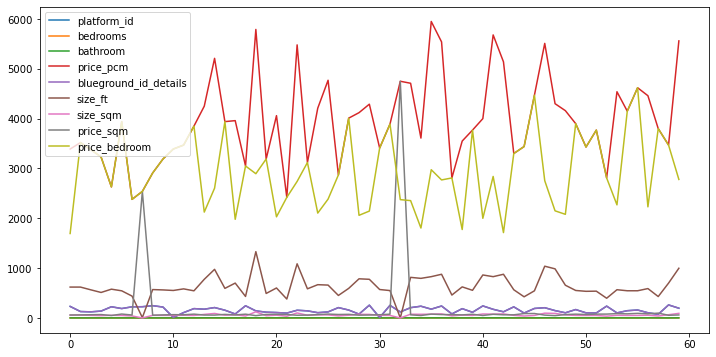

In [79]:
plot_df.plot(figsize=(12,6));


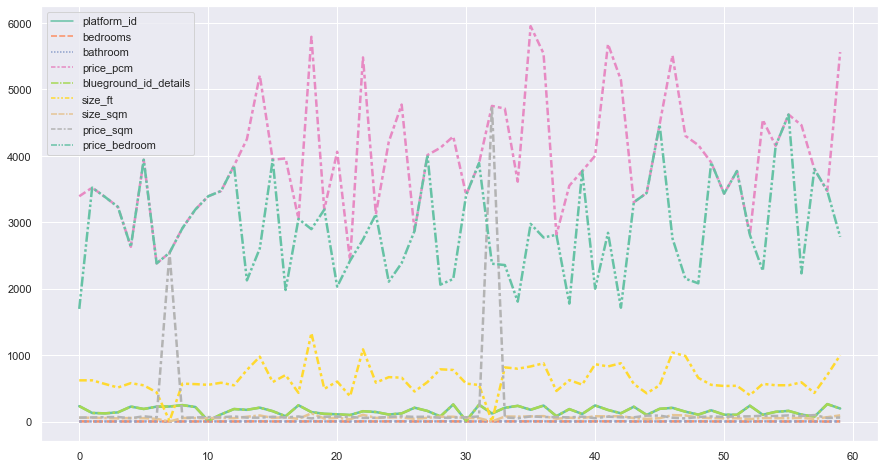

In [80]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=plot_df,  palette='Set2', linewidth=2.5, legend='auto');


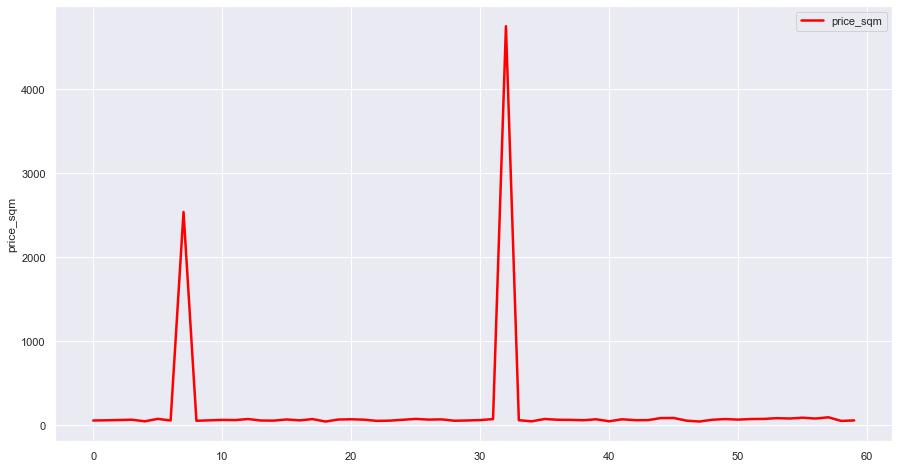

In [81]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=plot_df.price_sqm,  palette='Set2', linewidth=2.5, legend='auto', color='red', label='price_sqm');


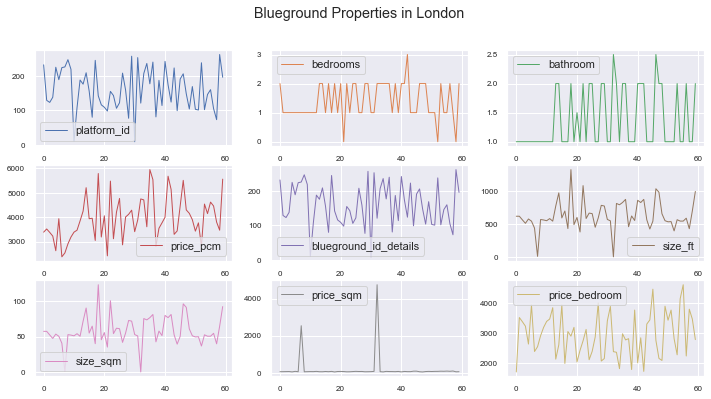

In [82]:
plot_df.plot(figsize=(12,6), subplots=True, layout=(3,3), sharex=False, sharey=False, legend=True, fontsize=8, title='Blueground Properties in London', linestyle='solid', linewidth=1, grid=True);

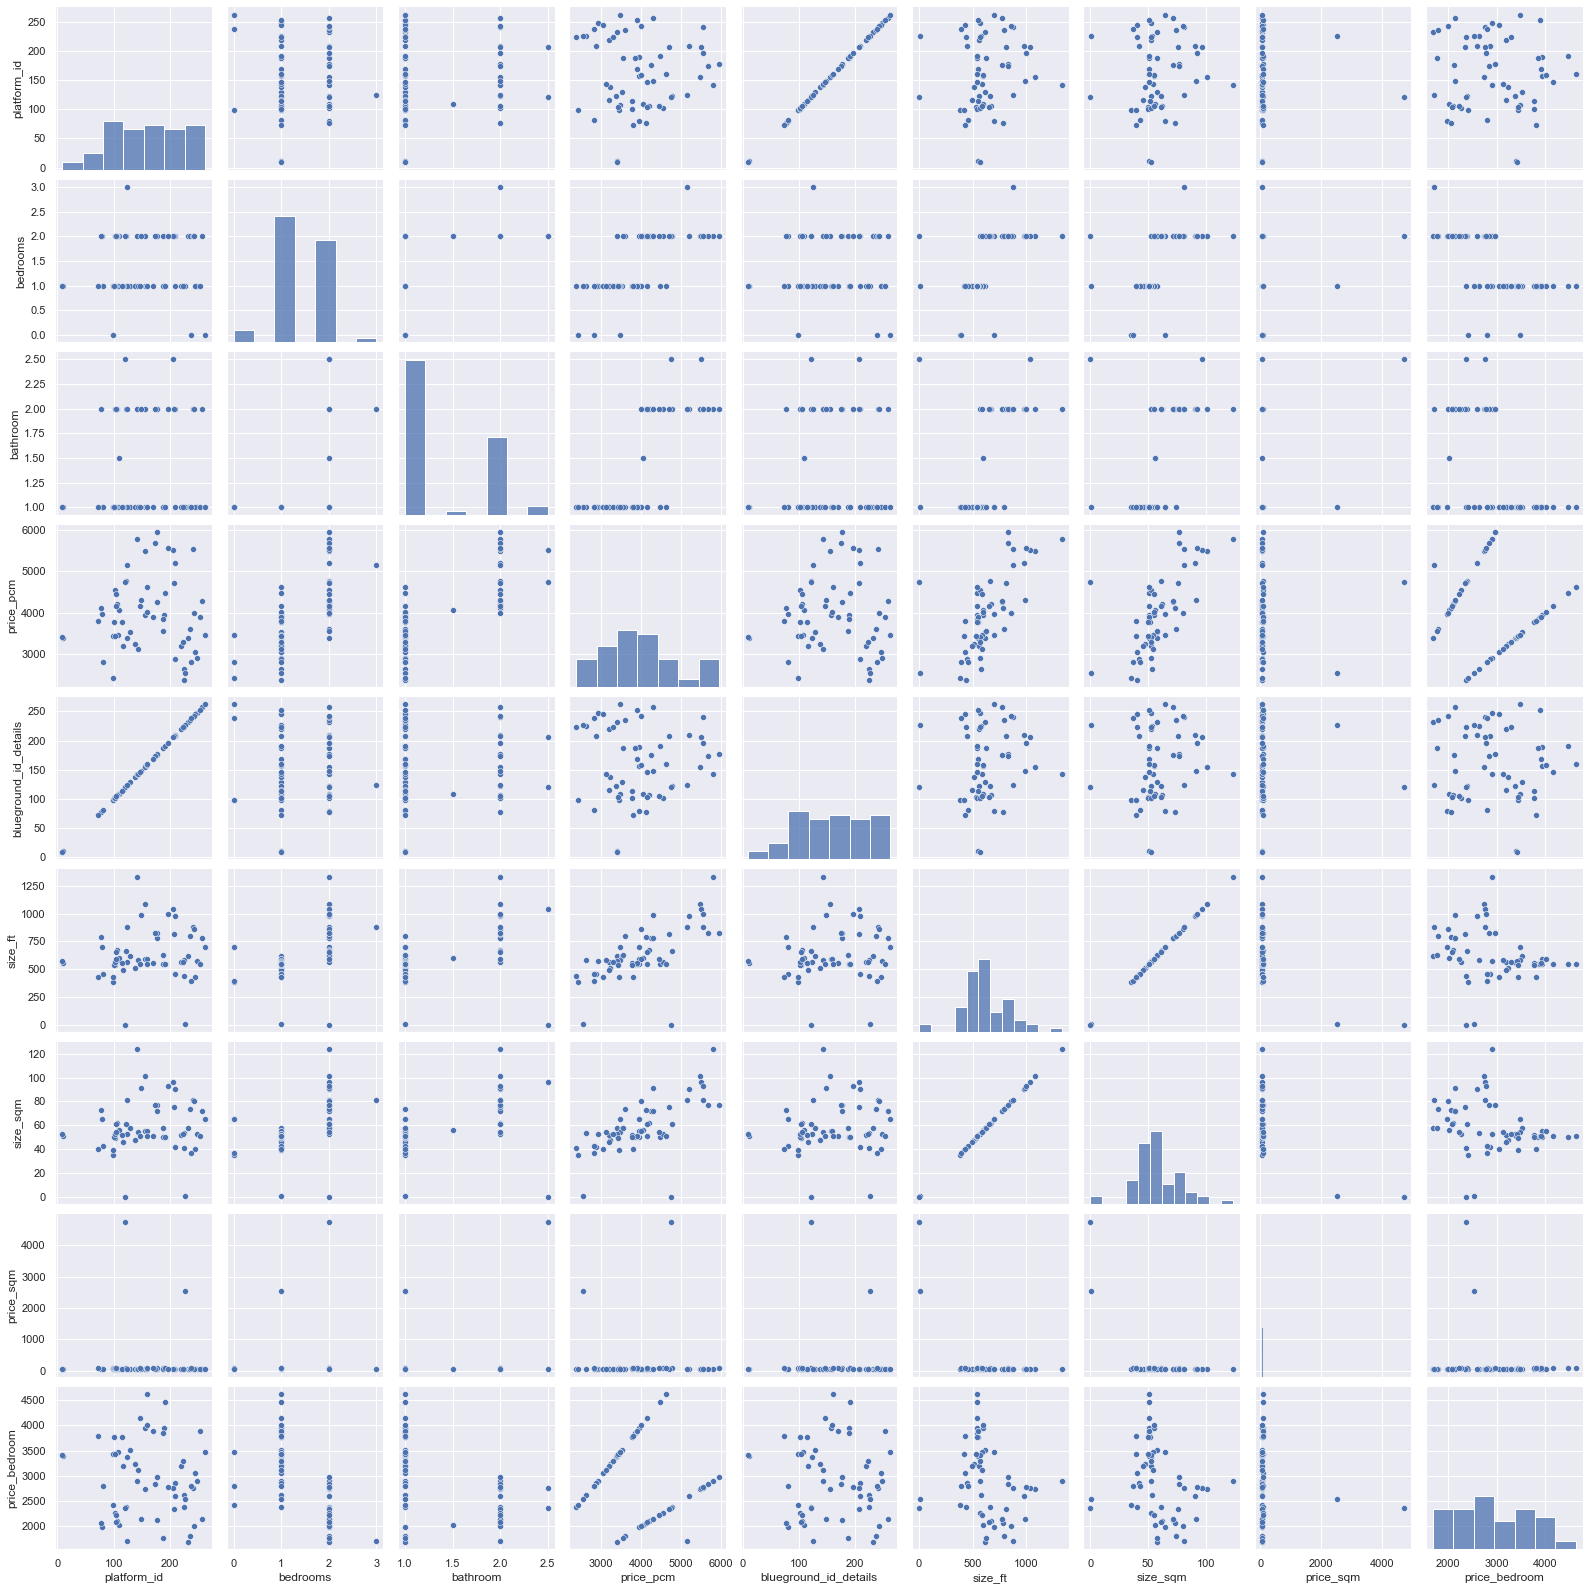

In [83]:
# Create the default pairplot
sns.pairplot(plot_df);

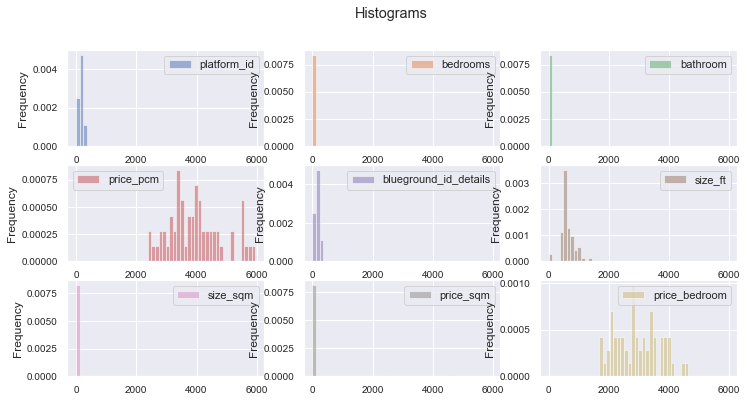

In [84]:
plot_df.plot(kind='hist', bins=50, figsize=(12,6), alpha=0.5, density=True, subplots=True, layout=(3,3), sharex=False, sharey=False, legend=True, title='Histograms',  fontsize=10, rot=0);

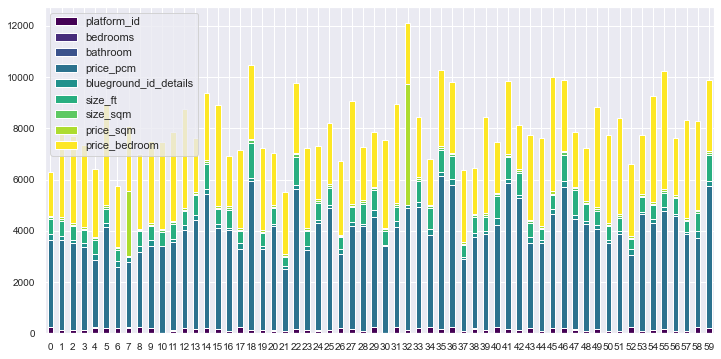

In [85]:
# Use kind='hbar' for horizontal bars, and stacked=True to stack the groups
plot_df.plot(kind='bar', stacked=True, figsize=(12, 6),   fontsize=10, rot=0, colormap='viridis',   sharex=False, sharey=False, legend=True,);


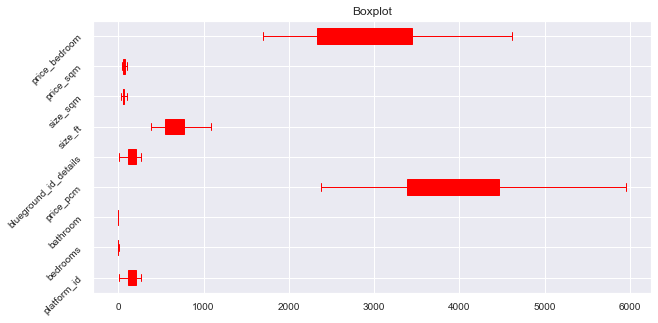

In [86]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# without outliners
plot_df.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=False, patch_artist=True, showfliers=False);

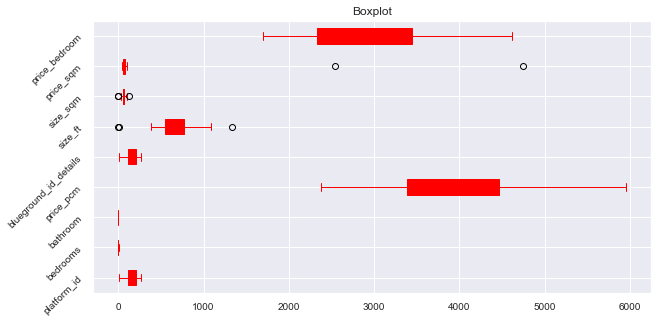

In [87]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_df.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=False, patch_artist=True, showfliers=True);

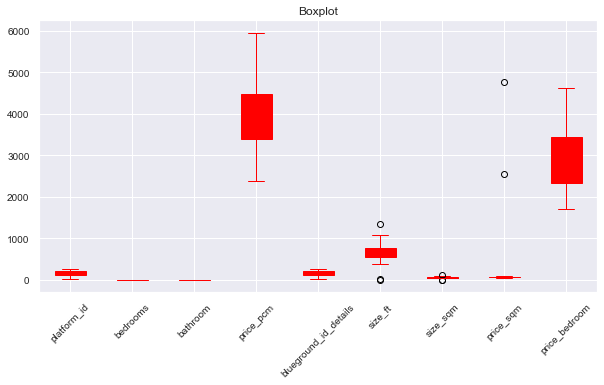

In [88]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_df.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=False, sharex=False, sharey=False);

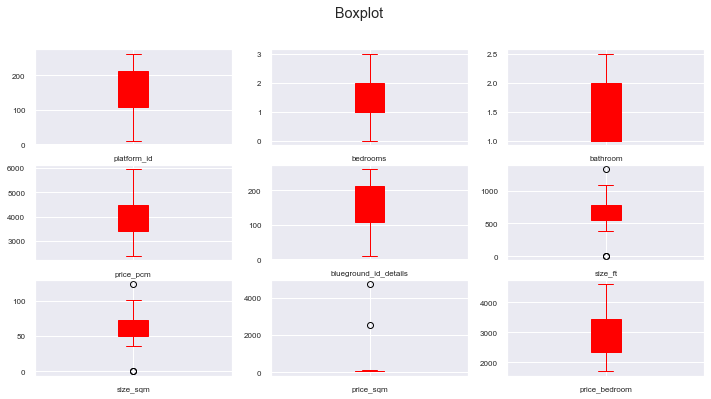

In [89]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_df.plot(kind='box', figsize=(12, 6), rot=0, fontsize=8, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=True, layout=(3, 3), legend=True);

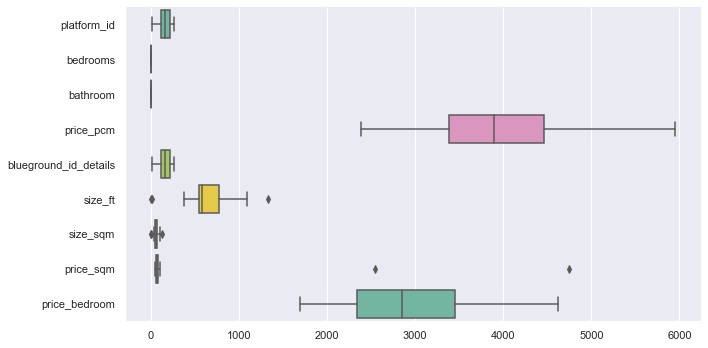

In [90]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.catplot( kind="box", data=plot_df, height=5, aspect=2, orient='h', palette='Set2');

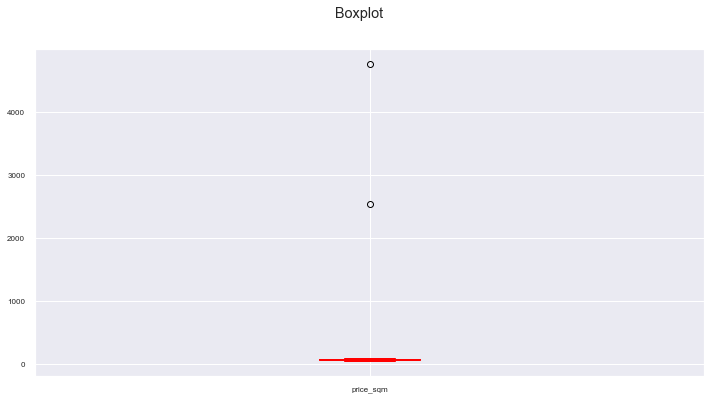

In [115]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_df.price_sqm.plot(kind='box', figsize=(12, 6), rot=0, fontsize=8, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=True,  legend=True);

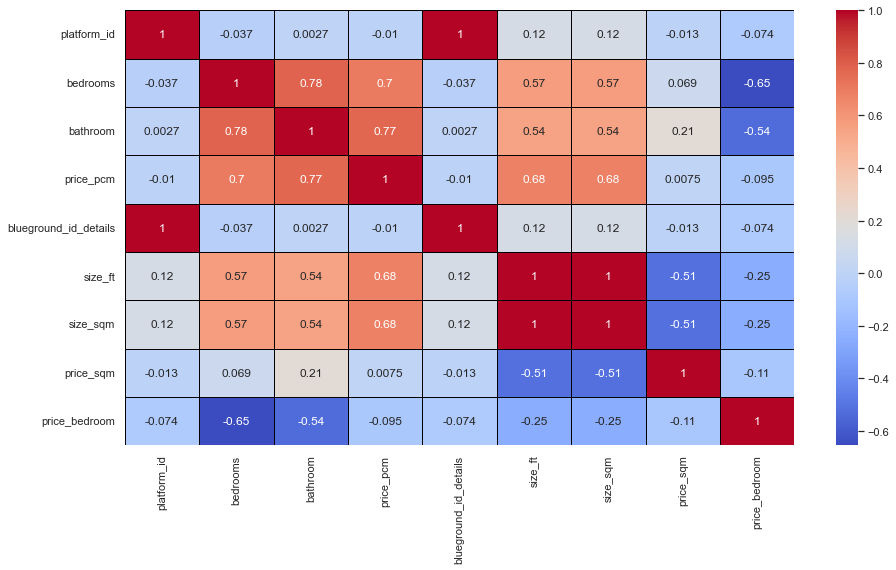

In [91]:
sns.heatmap(plot_df.corr(), annot=True, cmap='coolwarm', linewidths=1, linecolor='black');

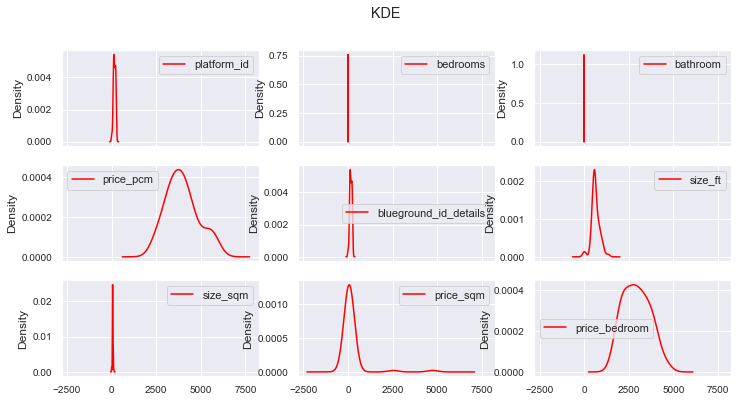

In [92]:
plot_df.plot(kind='kde', figsize=(12, 6), fontsize=10, grid=True, title='KDE', color='red', subplots=True, layout=(3, 3), legend=True);

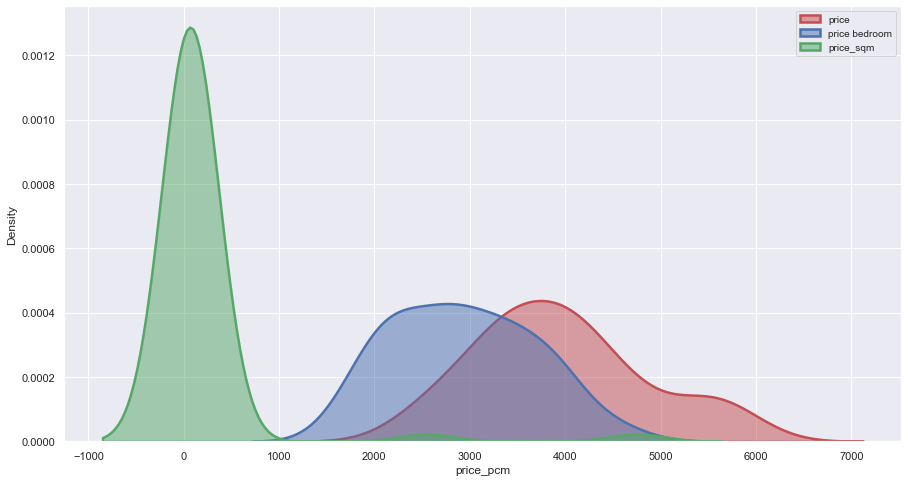

In [93]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(plot_df['price_pcm'], shade=True, color="r", label='price', alpha=0.5, linewidth=2.5, linestyle='solid')
fig = sns.kdeplot(plot_df['price_bedroom'], shade=True, color="b", label='price_bedroom', alpha=0.5, linewidth=2.5, linestyle='solid')
fig = sns.kdeplot(plot_df['price_sqm'], shade=True, color="g", label='price_sqm', alpha=0.5, linewidth=2.5, linestyle='solid')
fig.legend(labels=['price','price bedroom', 'price_sqm'], loc='upper right', fontsize=10)
plt.show()

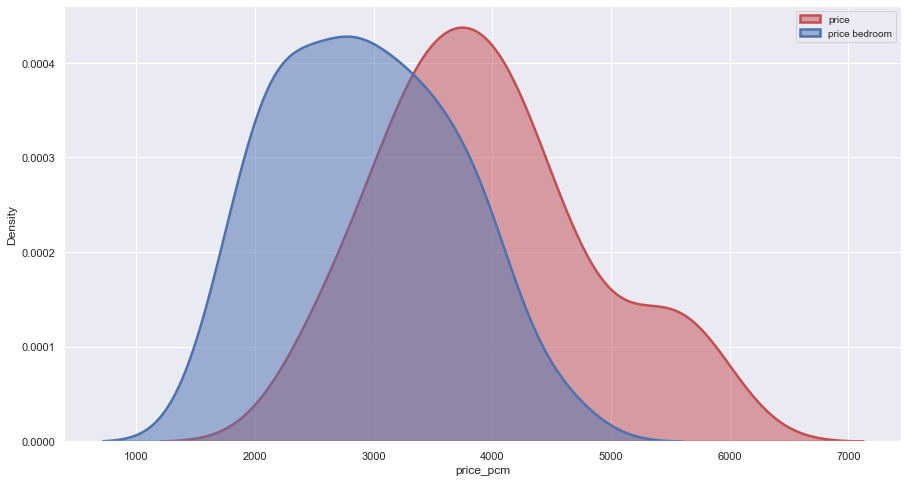

In [94]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

 
# plotting both distibutions on the same figure
fig = sns.kdeplot(plot_df['price_pcm'], shade=True, color="r", label='price', alpha=0.5, linewidth=2.5, linestyle='solid')
fig = sns.kdeplot(plot_df['price_bedroom'], shade=True, color="b", label='price_bedroom', alpha=0.5, linewidth=2.5, linestyle='solid')
fig.legend(labels=['price','price bedroom'], loc='upper right', fontsize=10)
plt.show()

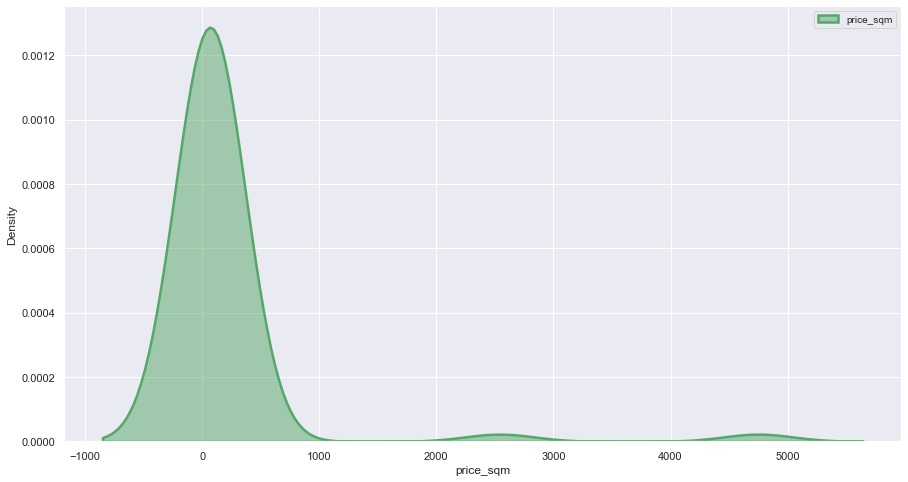

In [95]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(plot_df['price_sqm'], shade=True, color="g", label='price_sqm', alpha=0.5, linewidth=2.5, linestyle='solid', legend=True)
fig.legend(labels=[ 'price_sqm'], loc='upper right', fontsize=10)
plt.show()

--------

# We check for some problems, which we saw in the plots

In [96]:
df.sort_values(by=['price_sqm'], ascending=False).head(5)

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm,price_bedroom
32,121,Blueground,Lambeth,Apartment,2,2.5,4750,"Lower Marsh,",furnished,furnished,...,/furnished-apartments-london-uk/london-waterloo-121,121,floor,1.0,Floor,2022-10-21,,0.09,4750.00,2375.0
7,226,Blueground,Tower Hamlets,Apartment,1,1.0,2540,"Commercial Rd,",furnished,furnished,...,/furnished-apartments-london-uk/london-limehouse-226,226,floor,8.0,Floor,2022-10-21,,0.74,2540.00,2540.0
57,73,Blueground,Kensington and Chelsea,Apartment,1,1.0,3800,"Old Brompton Rd,",furnished,furnished,...,/furnished-apartments-london-uk/london-kensington-073,73,lotSizeSF,430.0,sq. ft.,2022-10-21,,39.95,97.44,3800.0
55,160,Blueground,Tower Hamlets,Apartment,1,1.0,4620,"New Drum St,",furnished,furnished,...,/furnished-apartments-london-uk/london-whitechapel-brick-lane-160,160,lotSizeSF,546.0,sq. ft.,2022-10-21,,50.72,92.40,4620.0
45,191,Blueground,Lambeth,Apartment,1,1.0,4470,"Legacy Building, Viaduct Gdns,",furnished,furnished,...,/furnished-apartments-london-uk/london-vauxhall-191,191,lotSizeSF,545.0,sq. ft.,2022-10-21,,50.63,89.40,4470.0


In [97]:
# Look for id 121, because the something is wrong with the data
df[df.caption == "Floor"]

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm,price_bedroom
7,226,Blueground,Tower Hamlets,Apartment,1,1.0,2540,"Commercial Rd,",furnished,furnished,...,/furnished-apartments-london-uk/london-limehouse-226,226,floor,8.0,Floor,2022-10-21,,0.74,2540.0,2540.0
32,121,Blueground,Lambeth,Apartment,2,2.5,4750,"Lower Marsh,",furnished,furnished,...,/furnished-apartments-london-uk/london-waterloo-121,121,floor,1.0,Floor,2022-10-21,,0.09,4750.0,2375.0


### we can see, that we have a problem with the calculaton of "Floor" and the "price_sqm"

In [98]:
# we look at the shape of the dataframe, so we can see the number of rows and columns
df.shape

(60, 23)

# We try to delete the rows with "Floor"
https://www.shanelynn.ie/pandas-drop-delete-dataframe-rows-columns/

In [99]:
# we have to drop the row with the caption "Floor"
# we check how many rows we have before dropping
df.loc[(df.caption == "Floor")]

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm,price_bedroom
7,226,Blueground,Tower Hamlets,Apartment,1,1.0,2540,"Commercial Rd,",furnished,furnished,...,/furnished-apartments-london-uk/london-limehouse-226,226,floor,8.0,Floor,2022-10-21,,0.74,2540.0,2540.0
32,121,Blueground,Lambeth,Apartment,2,2.5,4750,"Lower Marsh,",furnished,furnished,...,/furnished-apartments-london-uk/london-waterloo-121,121,floor,1.0,Floor,2022-10-21,,0.09,4750.0,2375.0


In [100]:
# https://www.shanelynn.ie/pandas-drop-delete-dataframe-rows-columns/
# we drop the rows with the caption "Floor"
df = df.loc[(df.caption != "Floor")]

In [101]:
# we check the rows after dropping
df.loc[(df.caption == "Floor")]

,platform_id,platform,neighbourhood,property_type,bedrooms,bathroom,price_pcm,title,furniture,detailed_furniture,...,get_url_to_detail_page,blueground_id_details,lotsize,size_ft,caption,scraping_date_details,let_type,size_sqm,price_sqm,price_bedroom


In [102]:
# we check the shape of the dataframe, so we can see the number of rows and columns
df.shape

(58, 23)

In [103]:
# we load the data again into our plot_df dataframe
plot_df_after_drop = df

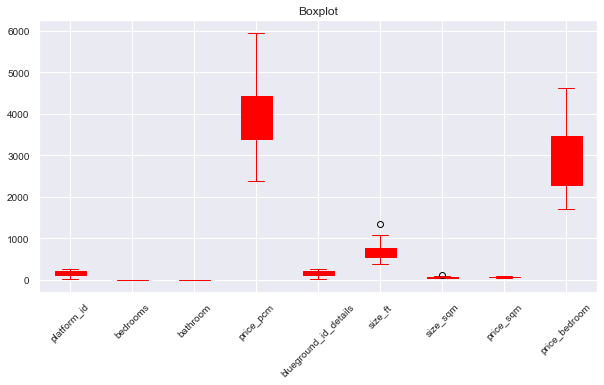

In [104]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners, which we just dropped
plot_df_after_drop.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=False, sharex=False, sharey=False);

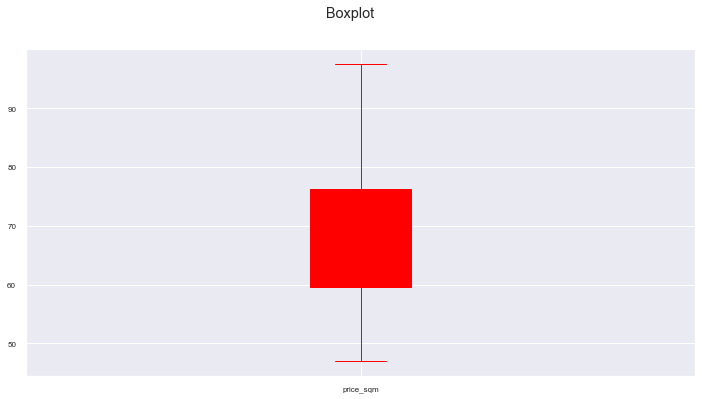

In [116]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_df_after_drop.price_sqm.plot(kind='box', figsize=(12, 6), rot=0, fontsize=8, grid=True, title='Price SQM after cleaning', color='red', vert=True, patch_artist=True, showfliers=True, subplots=True,  legend=True);

-------

# We now want to create a final Table, according to our structure

In [105]:
# Columns and their types
df.dtypes

platform_id                 int64
platform                   object
neighbourhood              object
property_type              object
bedrooms                    int64
bathroom                  float64
price_pcm                   int64
title                      object
furniture                  object
detailed_furniture         object
available_from             object
scraping_date_main         object
available_today            object
get_url_to_detail_page     object
blueground_id_details       int64
lotsize                    object
size_ft                   float64
caption                    object
scraping_date_details      object
let_type                   object
size_sqm                  float64
price_sqm                 float64
price_bedroom             float64
dtype: object

---------

# Give the clean data back to DBeaver to use it in Tableau

In [106]:
blueground_eda_cleaned = df

In [107]:
# call the schema created for this project
schema = 'capstone_jmrs'

# give the table a unique name
table_name = 'blueground_eda_cleaned'

# import the table to sql
if engine != None:
    try:
        blueground_eda_cleaned.to_sql(name=table_name,
                                   con=engine,
                                   if_exists='replace',
                                   schema=schema,
                                   index=False,
                                   chunksize=5000,
                                   method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The blueground_eda_cleaned table was imported successfully.


---------

# Create a Database, according to the agreed Project-Structure

In [108]:
 # Part  -  We now create a new table from the worked EDA data
 # https://stackoverflow.com/questions/14065408/how-do-i-merge-two-tables-in-postgresql

sql_text = f"""
CREATE TABLE {schema}.blueground_clean_01 AS
SELECT 
	platform_id AS platform_id, 
	platform AS platform,
	neighbourhood AS neighbourhood,
	furniture AS furniture,	
	property_type AS property_type,
	size_sqm AS size_sqm,
	bedrooms AS bedrooms,
	bathroom AS bathrooms,
	price_pcm AS price,
	price_sqm AS price_sqm,
	price_bedroom AS price_bedroom,
	available_from AS available_from,
	available_today AS available_today,
	let_type AS let_type,
	detailed_furniture AS detailed_furniture,
	scraping_date_main AS scraping_date
FROM capstone_jmrs.blueground_eda_cleaned ;
    """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

# Change Column-Type to the final structure

In [109]:
# Change Column-Type to final structure:

sql_text = f"""
 ALTER TABLE {schema}.blueground_clean_01
 ALTER COLUMN   platform_id	TYPE TEXT ,
  ALTER COLUMN   platform	  TYPE TEXT ,
   ALTER COLUMN   neighbourhood 	TYPE TEXT ,
    ALTER COLUMN   property_type	TYPE TEXT ,
      ALTER COLUMN   furniture	TYPE TEXT ,
        ALTER COLUMN detailed_furniture TYPE TEXT ,
         ALTER COLUMN   let_type	TYPE TEXT ,
          ALTER COLUMN  available_today 	TYPE TEXT ,
		 ALTER COLUMN  	bathrooms		  TYPE  float USING bathrooms::float,
		  ALTER COLUMN  	bedrooms		TYPE  float USING bedrooms::float,
		   ALTER COLUMN  	size_sqm		TYPE  float USING size_sqm::float,
		    ALTER COLUMN  	price	    TYPE  float USING price::float,
		     ALTER COLUMN  	price_sqm	TYPE  float USING price_sqm::float,
		      ALTER COLUMN  	price_bedroom		TYPE  float USING price_bedroom::float ;

        """ 
# Take the SQL-Command and execute it
result = engine.execute(sql_text)

In [110]:
sql_text = f"""
UPDATE {schema}.blueground_clean_01
SET let_type = NULL 
WHERE let_type = '';
"""
result = engine.execute(sql_text)

-----

# Save the final Table after every EDA

In [111]:
# Schema / Database configure:
schema = 'capstone_jmrs'

# Table name:
table_name = 'blueground_clean_01'

In [112]:
# Select the combined Data form DBeaver Database

sql = f"""
SELECT *
FROM {schema}.{table_name} as blueground_clean_01
""" 
# to the variable aq_august
last_save = get_dataframe(sql) 

In [113]:
# ----------------- save the dataframes in a .csv file -----------------
today = dt.datetime.today().strftime('%Y-%m-%d-%H-%M')
last_save.to_csv('data/blueground_clean_{}.csv'.format(today), sep='\t')
print("we have saved the new dataframes in a .csv file")

OSError: Cannot save file into a non-existent directory: 'data'

------

# Now we want to see some plots with the cleaned data
> this data will be used to merge all Tables to a new table with information from all other project members

In [117]:
# Schema / Database configure:
schema = 'capstone_jmrs'

# Table name:
table_name = 'blueground_clean_01'


In [118]:
# Select the combined Data form DBeaver Database

sql = f"""
SELECT *
FROM {schema}.{table_name} as blueground_clean_01
""" 
# Take the SQL-Command and import all Data into the variable df
blueground_clean = get_dataframe(sql) 
blueground_clean = blueground_clean.copy()
display(blueground_clean.head(3))

,platform_id,platform,neighbourhood,furniture,property_type,size_sqm,bedrooms,bathrooms,price,price_sqm,price_bedroom,available_from,available_today,let_type,detailed_furniture,scraping_date
0,232,Blueground,Islington,furnished,Apartment,57.60,2.0,1.0,3390.0,59.47,1695.0,2022-11-20,occupied,None,furnished,2022-10-21
1,129,Blueground,Lambeth,furnished,Apartment,57.60,1.0,1.0,3520.0,61.75,3520.0,2022-11-20,occupied,None,furnished,2022-10-21
2,123,Blueground,Lambeth,furnished,Apartment,52.49,1.0,1.0,3380.0,65.00,3380.0,2022-11-21,occupied,None,furnished,2022-10-21


In [119]:
plot_blueground_clean = blueground_clean

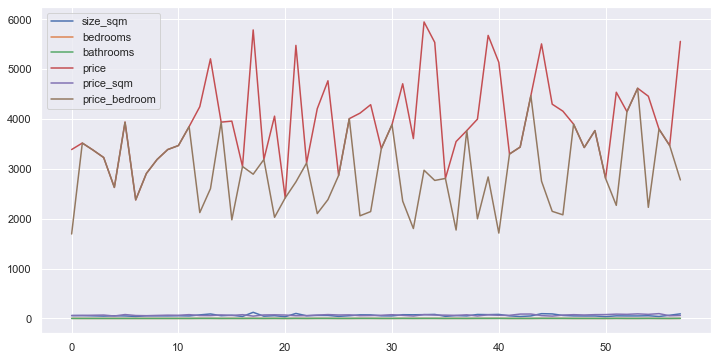

In [120]:
plot_blueground_clean.plot(figsize=(12,6));

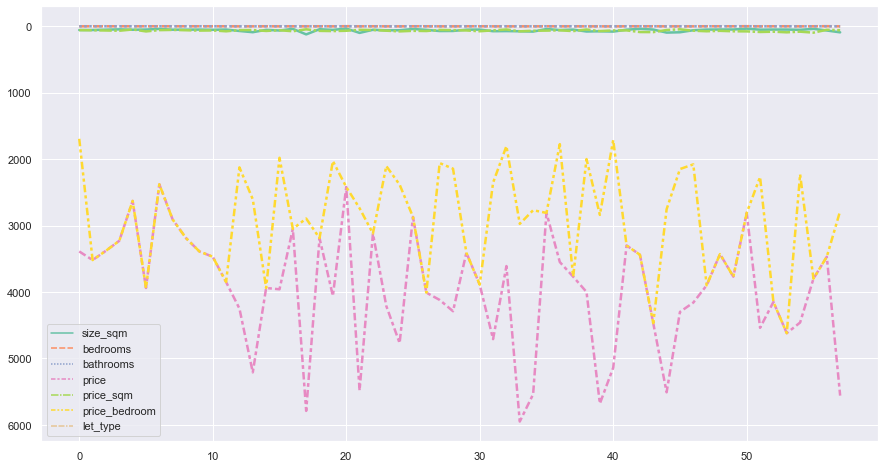

In [121]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=plot_blueground_clean,  palette='Set2', linewidth=2.5, legend='auto');


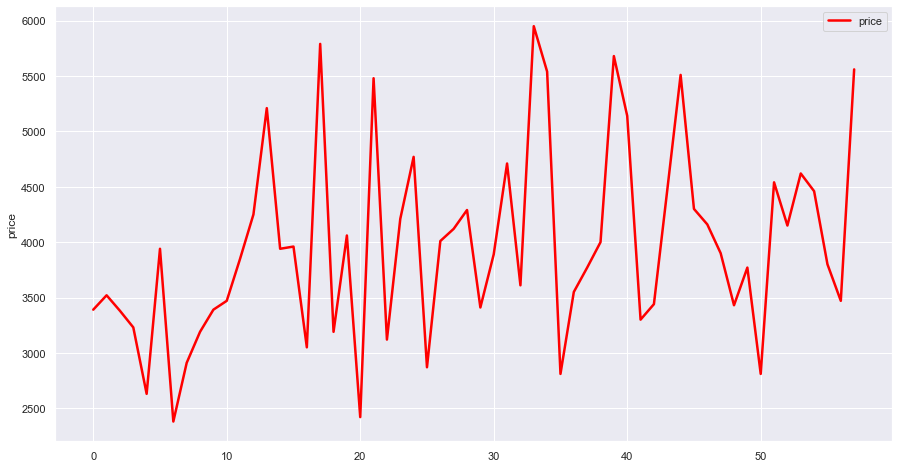

In [122]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=plot_blueground_clean.price,  palette='Set2', linewidth=2.5, legend='auto', color='red', label='price');


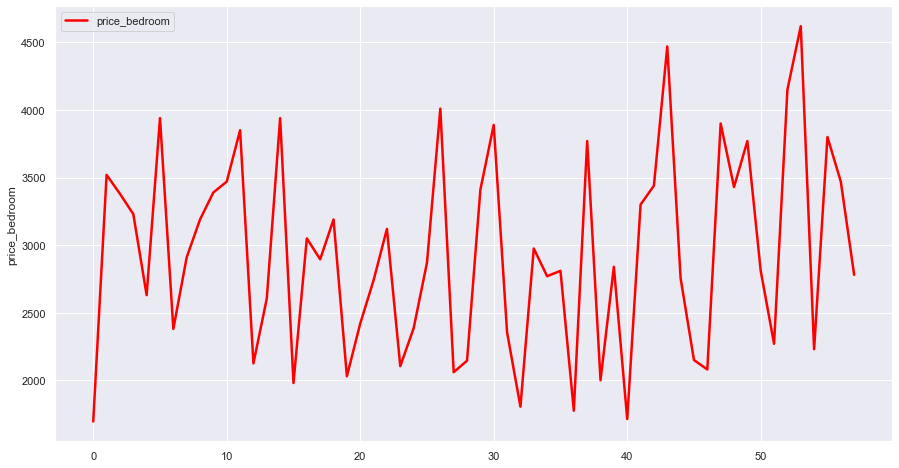

In [123]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=plot_blueground_clean.price_bedroom,  palette='Set2', linewidth=2.5, legend='auto', color='red', label='price_bedroom');


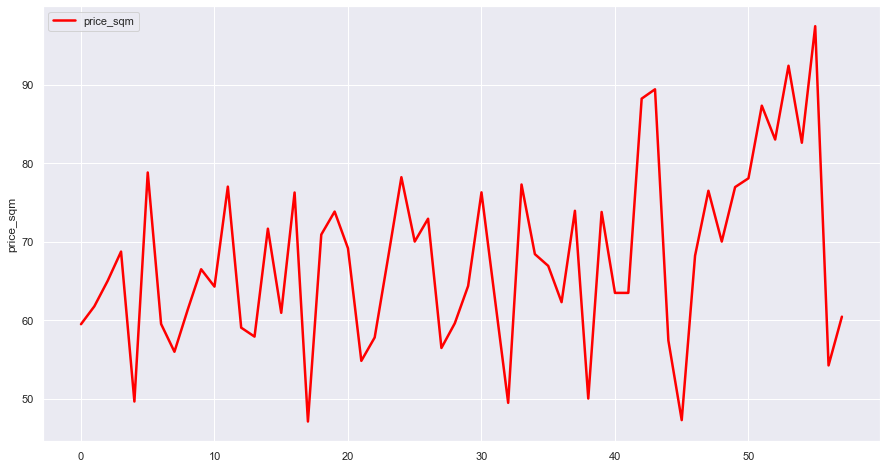

In [124]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=plot_blueground_clean.price_sqm,  palette='Set2', linewidth=2.5, legend='auto', color='red', label='price_sqm');


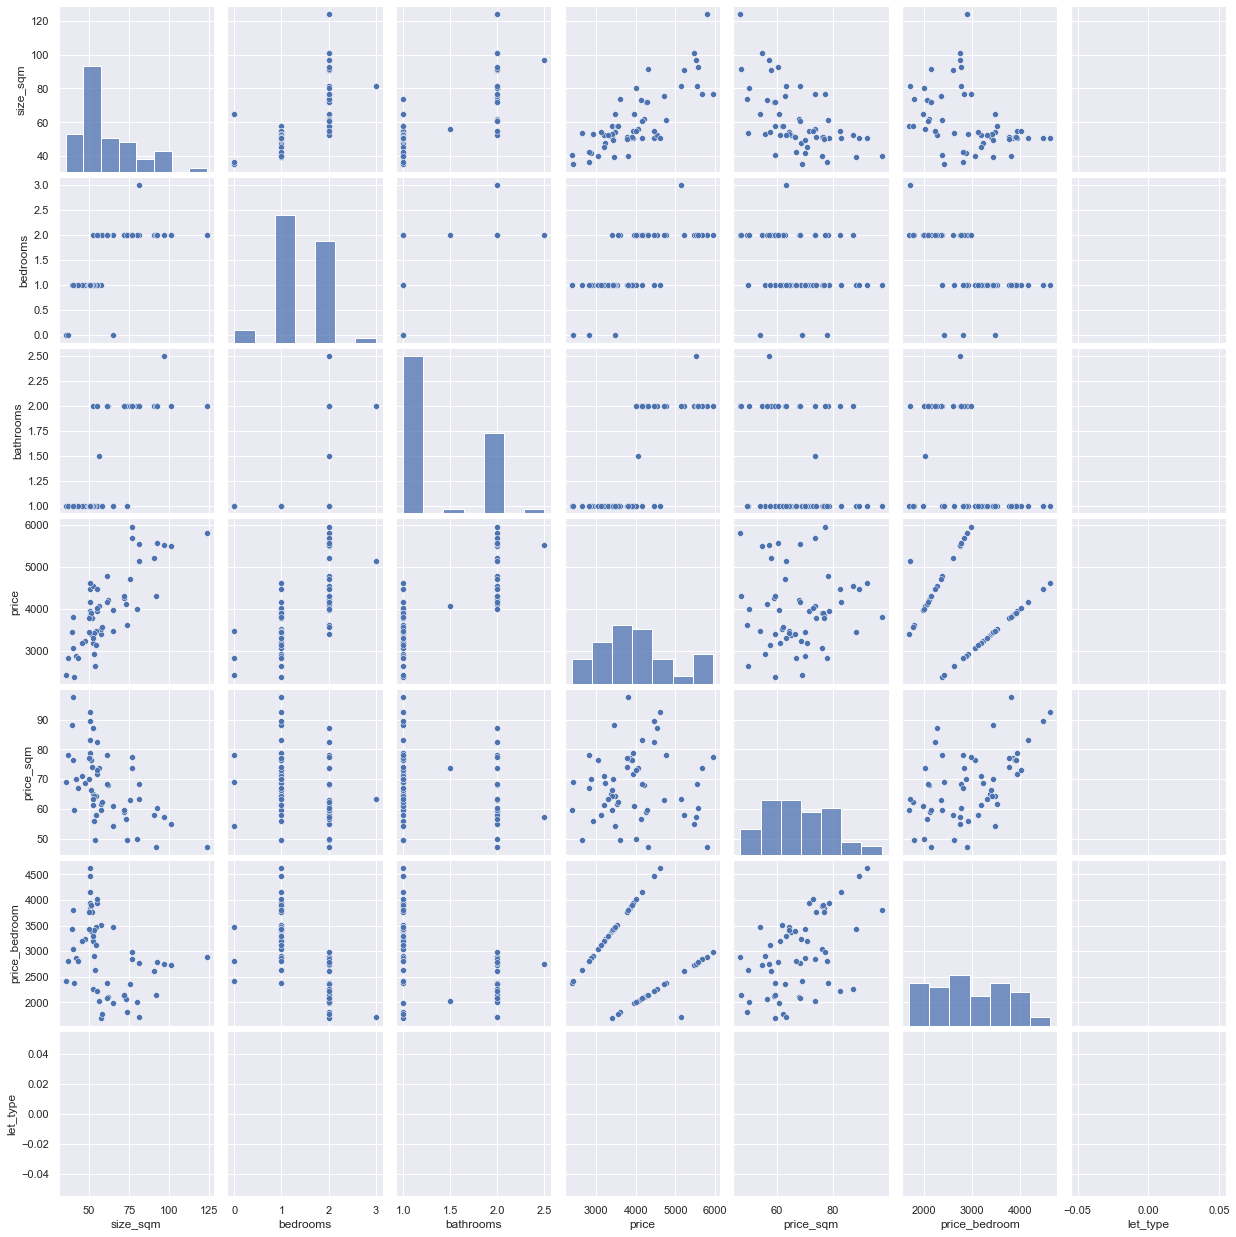

In [125]:
# Create the default pairplot
sns.pairplot(plot_blueground_clean);

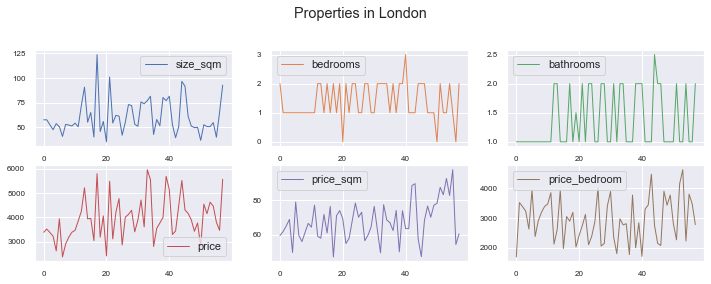

In [126]:
plot_blueground_clean.plot(figsize=(12,6), subplots=True, layout=(3,3), sharex=False, sharey=False, legend=True, fontsize=8, title=' Properties in London', linestyle='solid', linewidth=1, grid=True);

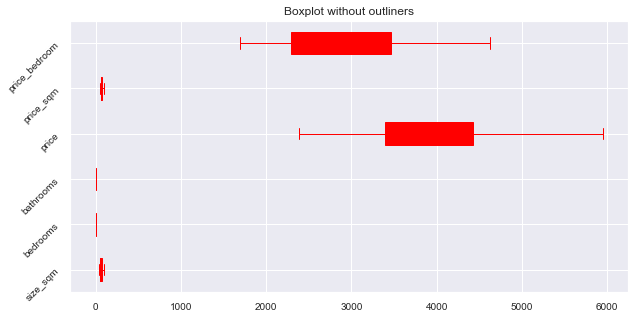

In [127]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# without outliners
plot_blueground_clean.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot without outliners', color='red', vert=False, patch_artist=True, showfliers=False);

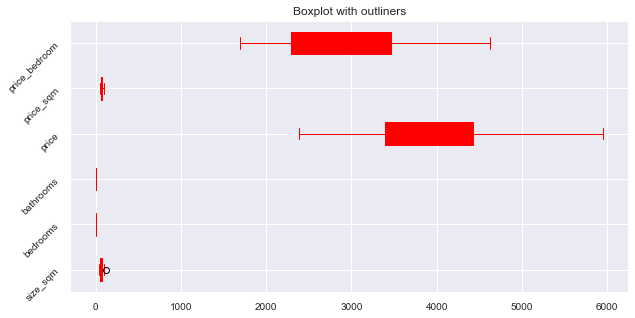

In [128]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_blueground_clean.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot with outliners', color='red', vert=False, patch_artist=True, showfliers=True);

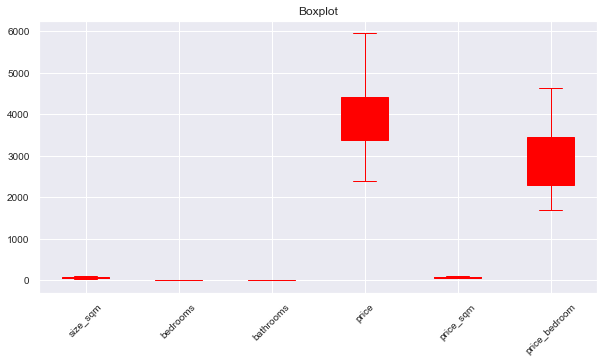

In [129]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_blueground_clean.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=False, subplots=False, sharex=False, sharey=False);

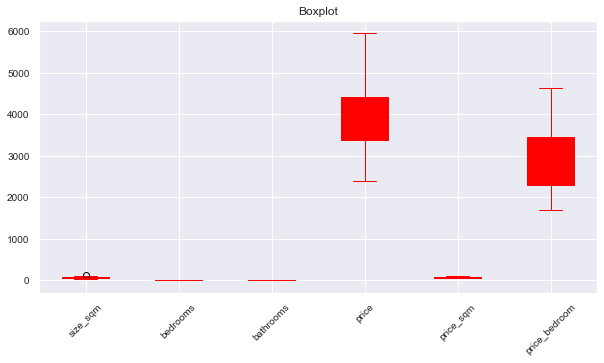

In [130]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_blueground_clean.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=False, sharex=False, sharey=False);

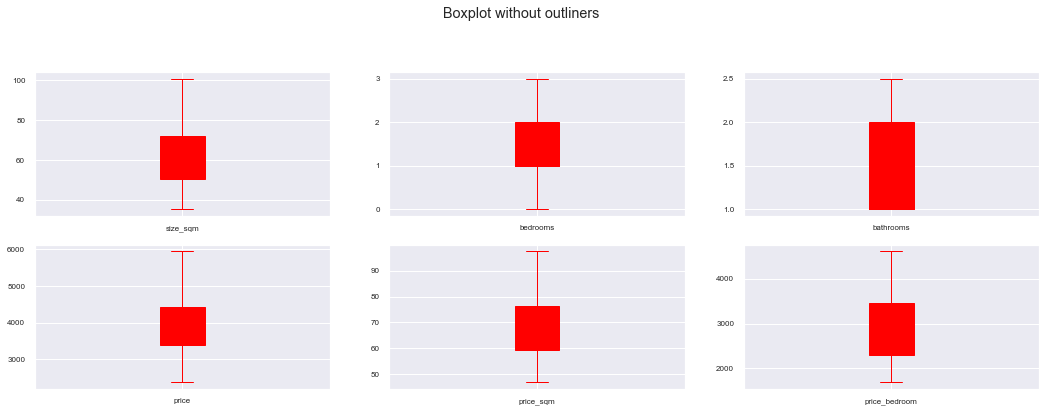

In [131]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# without outliners
plot_blueground_clean.plot(kind='box', figsize=(18, 9), rot=0, fontsize=8, grid=True, title='Boxplot without outliners', color='red', vert=True, patch_artist=True, showfliers=False, subplots=True, layout=(3, 3), legend=True);

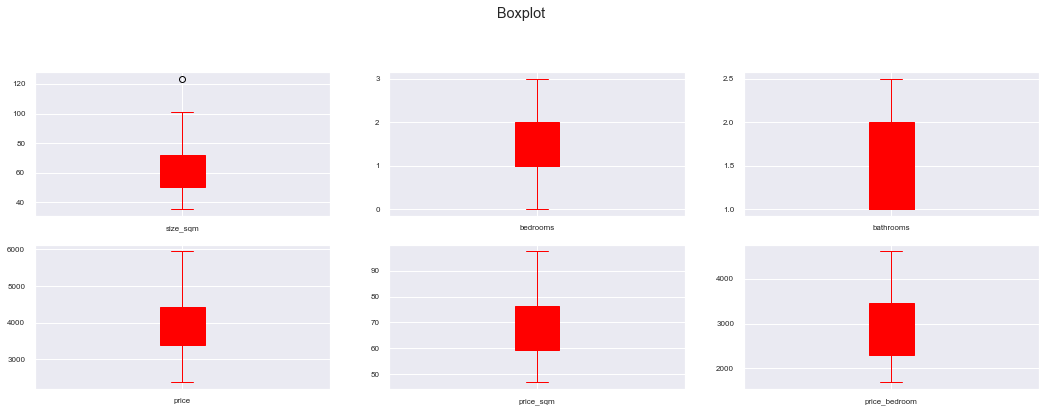

In [132]:
# Boxplots are displayed with the kind=’box’ options. Each box represents a numeric column.

# with outliners
plot_blueground_clean.plot(kind='box', figsize=(18, 9), rot=0, fontsize=8, grid=True, title='Boxplot', color='red', vert=True, patch_artist=True, showfliers=True, subplots=True, layout=(3, 3), legend=True);

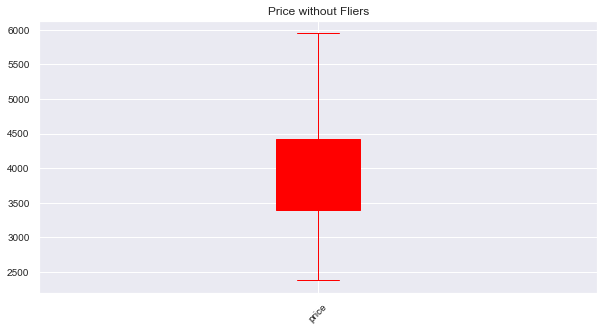

In [133]:
plot_blueground_clean.price.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Price without Fliers', color='red', vert=True, patch_artist=True, showfliers=False, subplots=False, sharex=False, sharey=False);

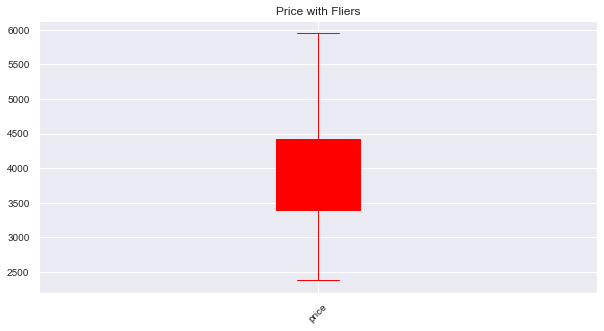

In [134]:
plot_blueground_clean.price.plot(kind='box', figsize=(10, 5), rot=45, fontsize=10, grid=True, title='Price with Fliers', color='red', vert=True, patch_artist=True, showfliers=True, subplots=False, sharex=False, sharey=False);

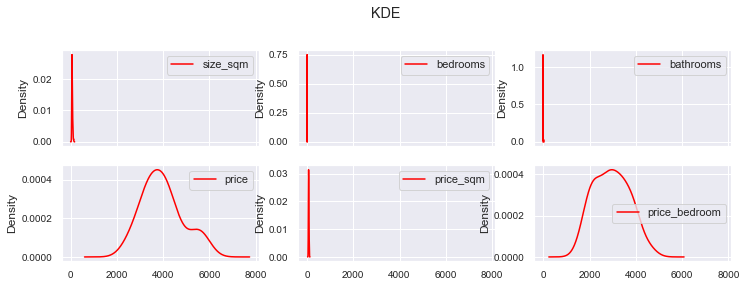

In [135]:
plot_blueground_clean.plot(kind='kde', figsize=(12, 6), fontsize=10, grid=True, title='KDE', color='red', subplots=True, layout=(3, 3), legend=True);

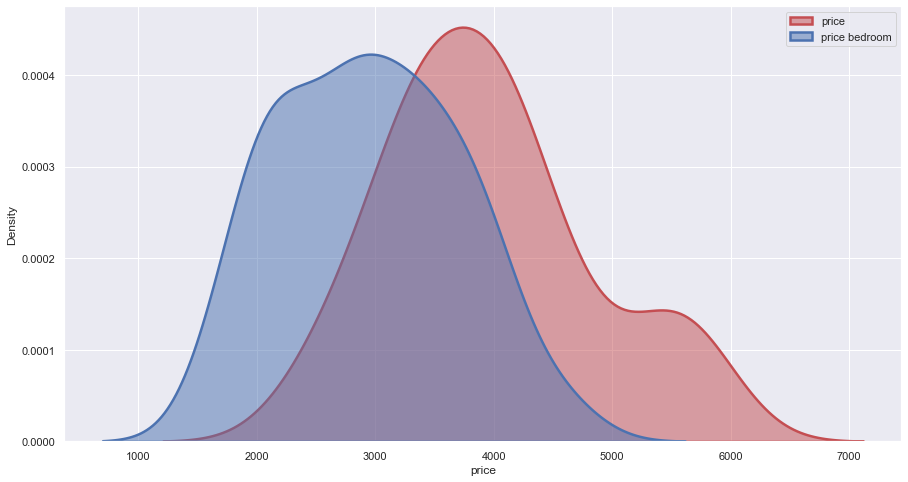

In [136]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(plot_blueground_clean['price'], shade=True, color="r", label='price', alpha=0.5, linewidth=2.5, linestyle='solid')
fig = sns.kdeplot(plot_blueground_clean['price_bedroom'], shade=True, color="b", label='price_bedroom', alpha=0.5, linewidth=2.5, linestyle='solid')
fig.legend(labels=['price','price bedroom'])
plt.show()

# Matplotlib boxplots with custom percentiles

https://jwalton.info/Matplotlib-custom-boxplots/

https://www.codegrepper.com/code-examples/python/how+to+find+the+75th+percentile+in+pandas

In [137]:
# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

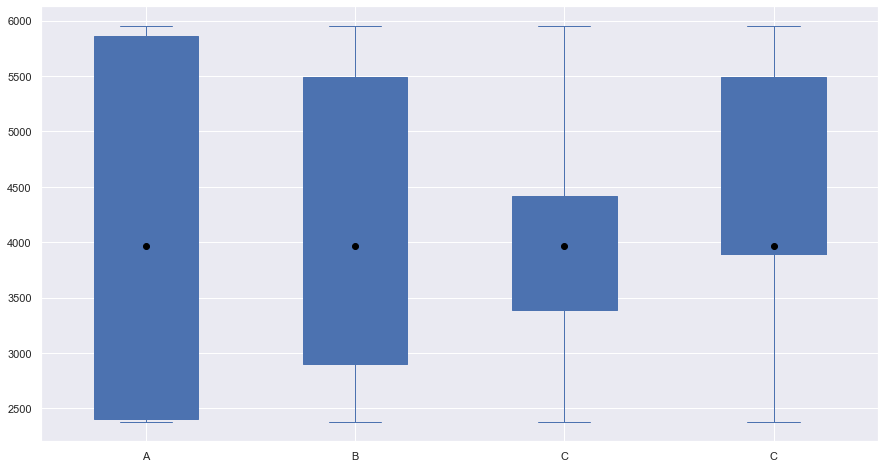

In [138]:
# Generate some random data to visualise
data = plot_blueground_clean.price  #np.random.normal(size=100)

stats = {}

# Compute the boxplot stats with our desired percentiles
stats['A'] = my_boxplot_stats(data, labels='A', percents=[1, 99])[0]
stats['B'] = my_boxplot_stats(data, labels='B', percents=[10, 90])[0]
stats['C'] = my_boxplot_stats(data, labels='C', percents=[25, 75])[0]
stats['D'] = my_boxplot_stats(data, labels='C', percents=[50, 90])[0]

fig, ax = plt.subplots(1, 1)
# Plot boxplots from our computed statistics
# bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3), showfliers=False, patch_artist=True, widths=0.5, medianprops={'color': 'black'}
#     , boxprops={'facecolor': 'white', 'edgecolor': 'black'}, whiskerprops={'color': 'black'}, capprops={'color': 'black'}, 
#     showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black'}
# , meanline=True, showcaps=True, showbox=True,  vert=True)

bp = ax.bxp([stats['A'], stats['B'], stats['C'],stats['D']], positions=range(4), 
    showfliers=False, 
    patch_artist=True, widths=0.5, 
    medianprops={'color': 'black'}, 
    boxprops={'facecolor': 'white', 'edgecolor': 'black'}, 
    whiskerprops={'color': 'black'}, capprops={'color': 'black'}, 
    showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black'}
    
    )

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

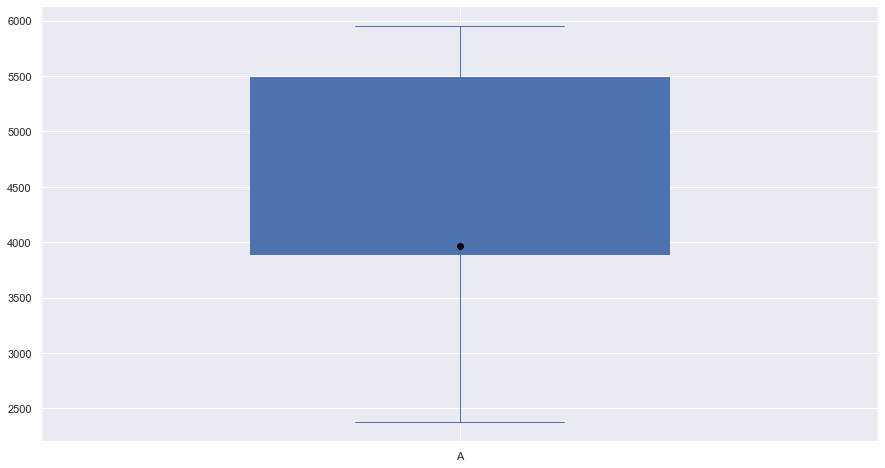

In [139]:
# Generate some random data to visualise
np.random.seed(2019)
data = plot_blueground_clean.price  #np.random.normal(size=100)

stats = {}

# Compute the boxplot stats with our desired percentiles
stats['A'] = my_boxplot_stats(data, labels='A', percents=[50, 90])[0]

fig, ax = plt.subplots(1, 1)

bp = ax.bxp([stats['A']], positions=range(1), 
    showfliers=False, 
    patch_artist=True, widths=0.5, 
    medianprops={'color': 'black'}, 
    boxprops={'facecolor': 'white', 'edgecolor': 'black'}, 
    whiskerprops={'color': 'black'}, capprops={'color': 'black'}, 
    showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black'}
    
    )

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')